In [18]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, recall_score
from fairlearn.metrics import MetricFrame, true_positive_rate, false_positive_rate, equalized_odds_difference

In [6]:
file_path = r"C:\Users\olasu\Downloads\compas_data.csv"
data = pd.read_csv(file_path)

class_distribution = data['Reoffending_Likelihood'].value_counts()
print(class_distribution)

Reoffending_Likelihood
1    3963
2    3251
Name: count, dtype: int64


In [11]:
combined_categories = data['sex'] + "_" + data['Age_class'] + "_" + data['race_class']
# Apply one-hot encoding to these combined categories
combined_one_hot_encoded = pd.get_dummies(combined_categories)
combined_one_hot_encoded.columns = combined_one_hot_encoded.columns.str.lower()

new_data = data.join(combined_one_hot_encoded)
new_data = new_data.drop(["race_class", "age", "Age_class", 'sex'], axis = 1)

categorical_features = new_data.select_dtypes(include=['object', 'bool'])
for col in categorical_features:
    le = LabelEncoder()
    new_data[col] = new_data[col].fillna('missing')
    new_data[col] = le.fit_transform(new_data[col])
print(new_data.columns)

Index(['juv_fel_count', 'decile_score', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'c_charge_degree', 'decile_score.1', 'score_text',
       'v_decile_score', 'v_score_text', 'priors_count.1', 'start', 'end',
       'Reoffending_Likelihood', 'female_adult_other', 'female_adult_white',
       'female_young_other', 'female_young_white', 'male_adult_other',
       'male_adult_white', 'male_young_other', 'male_young_white'],
      dtype='object')


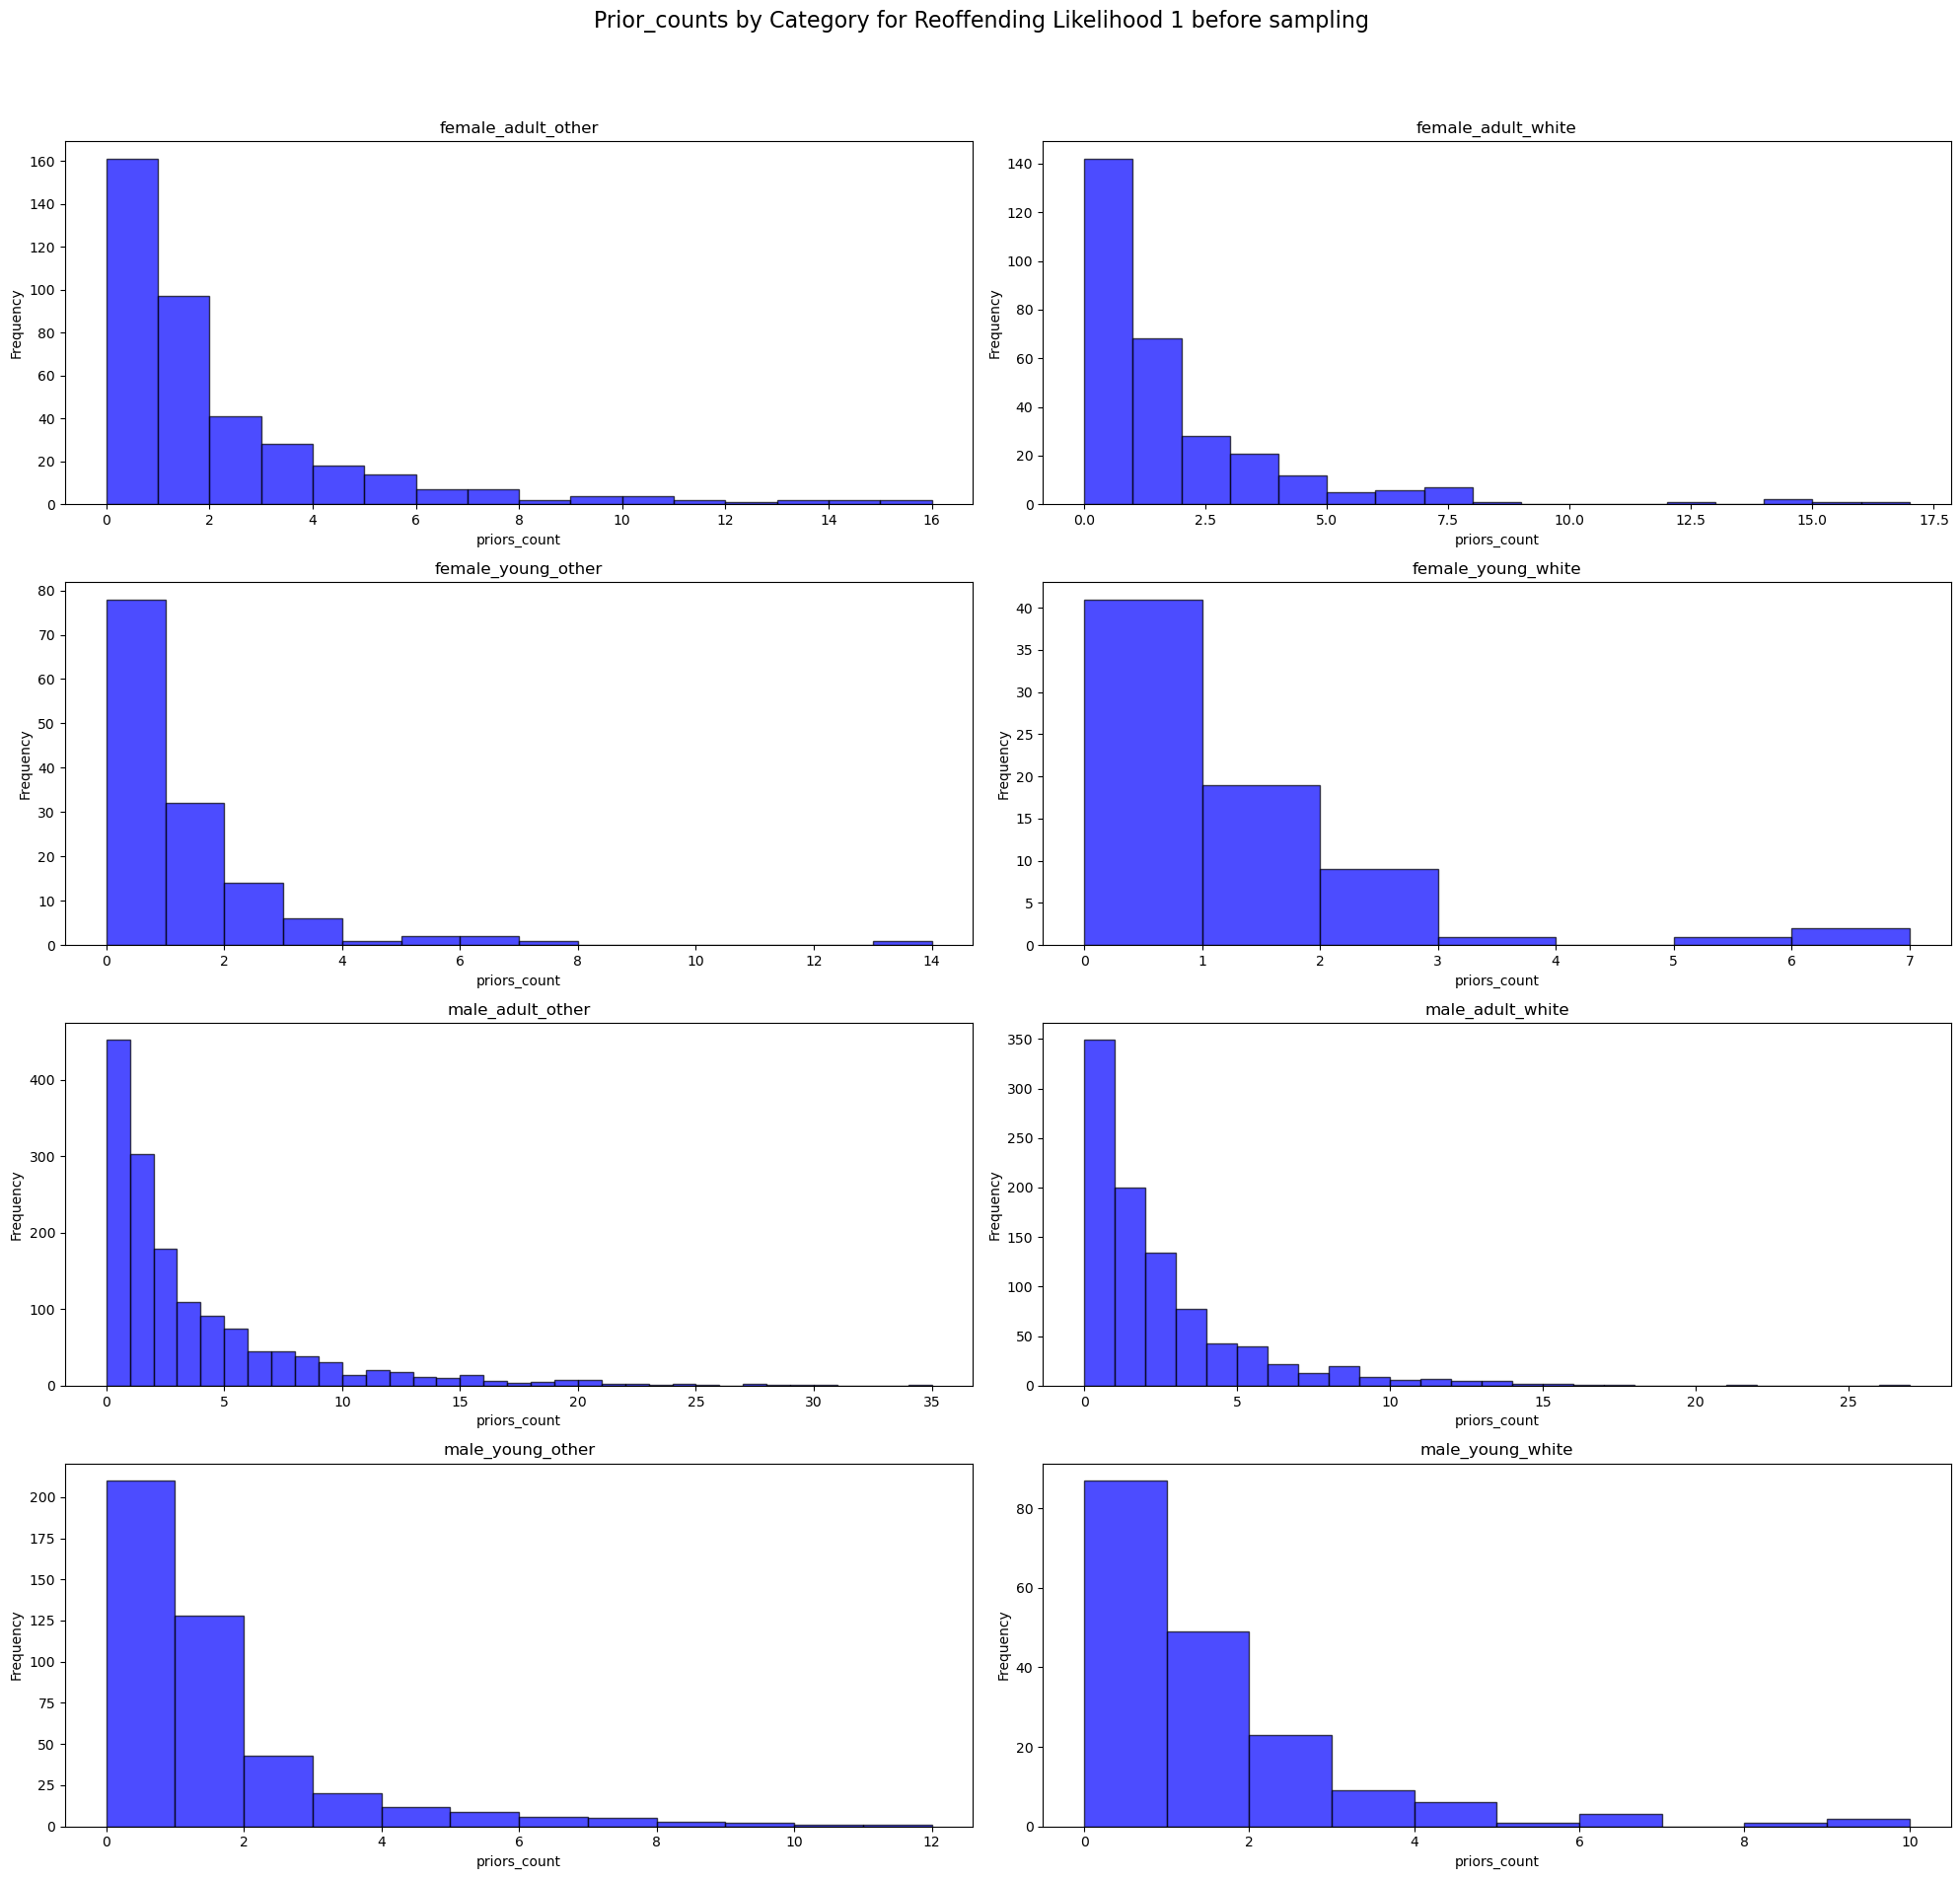

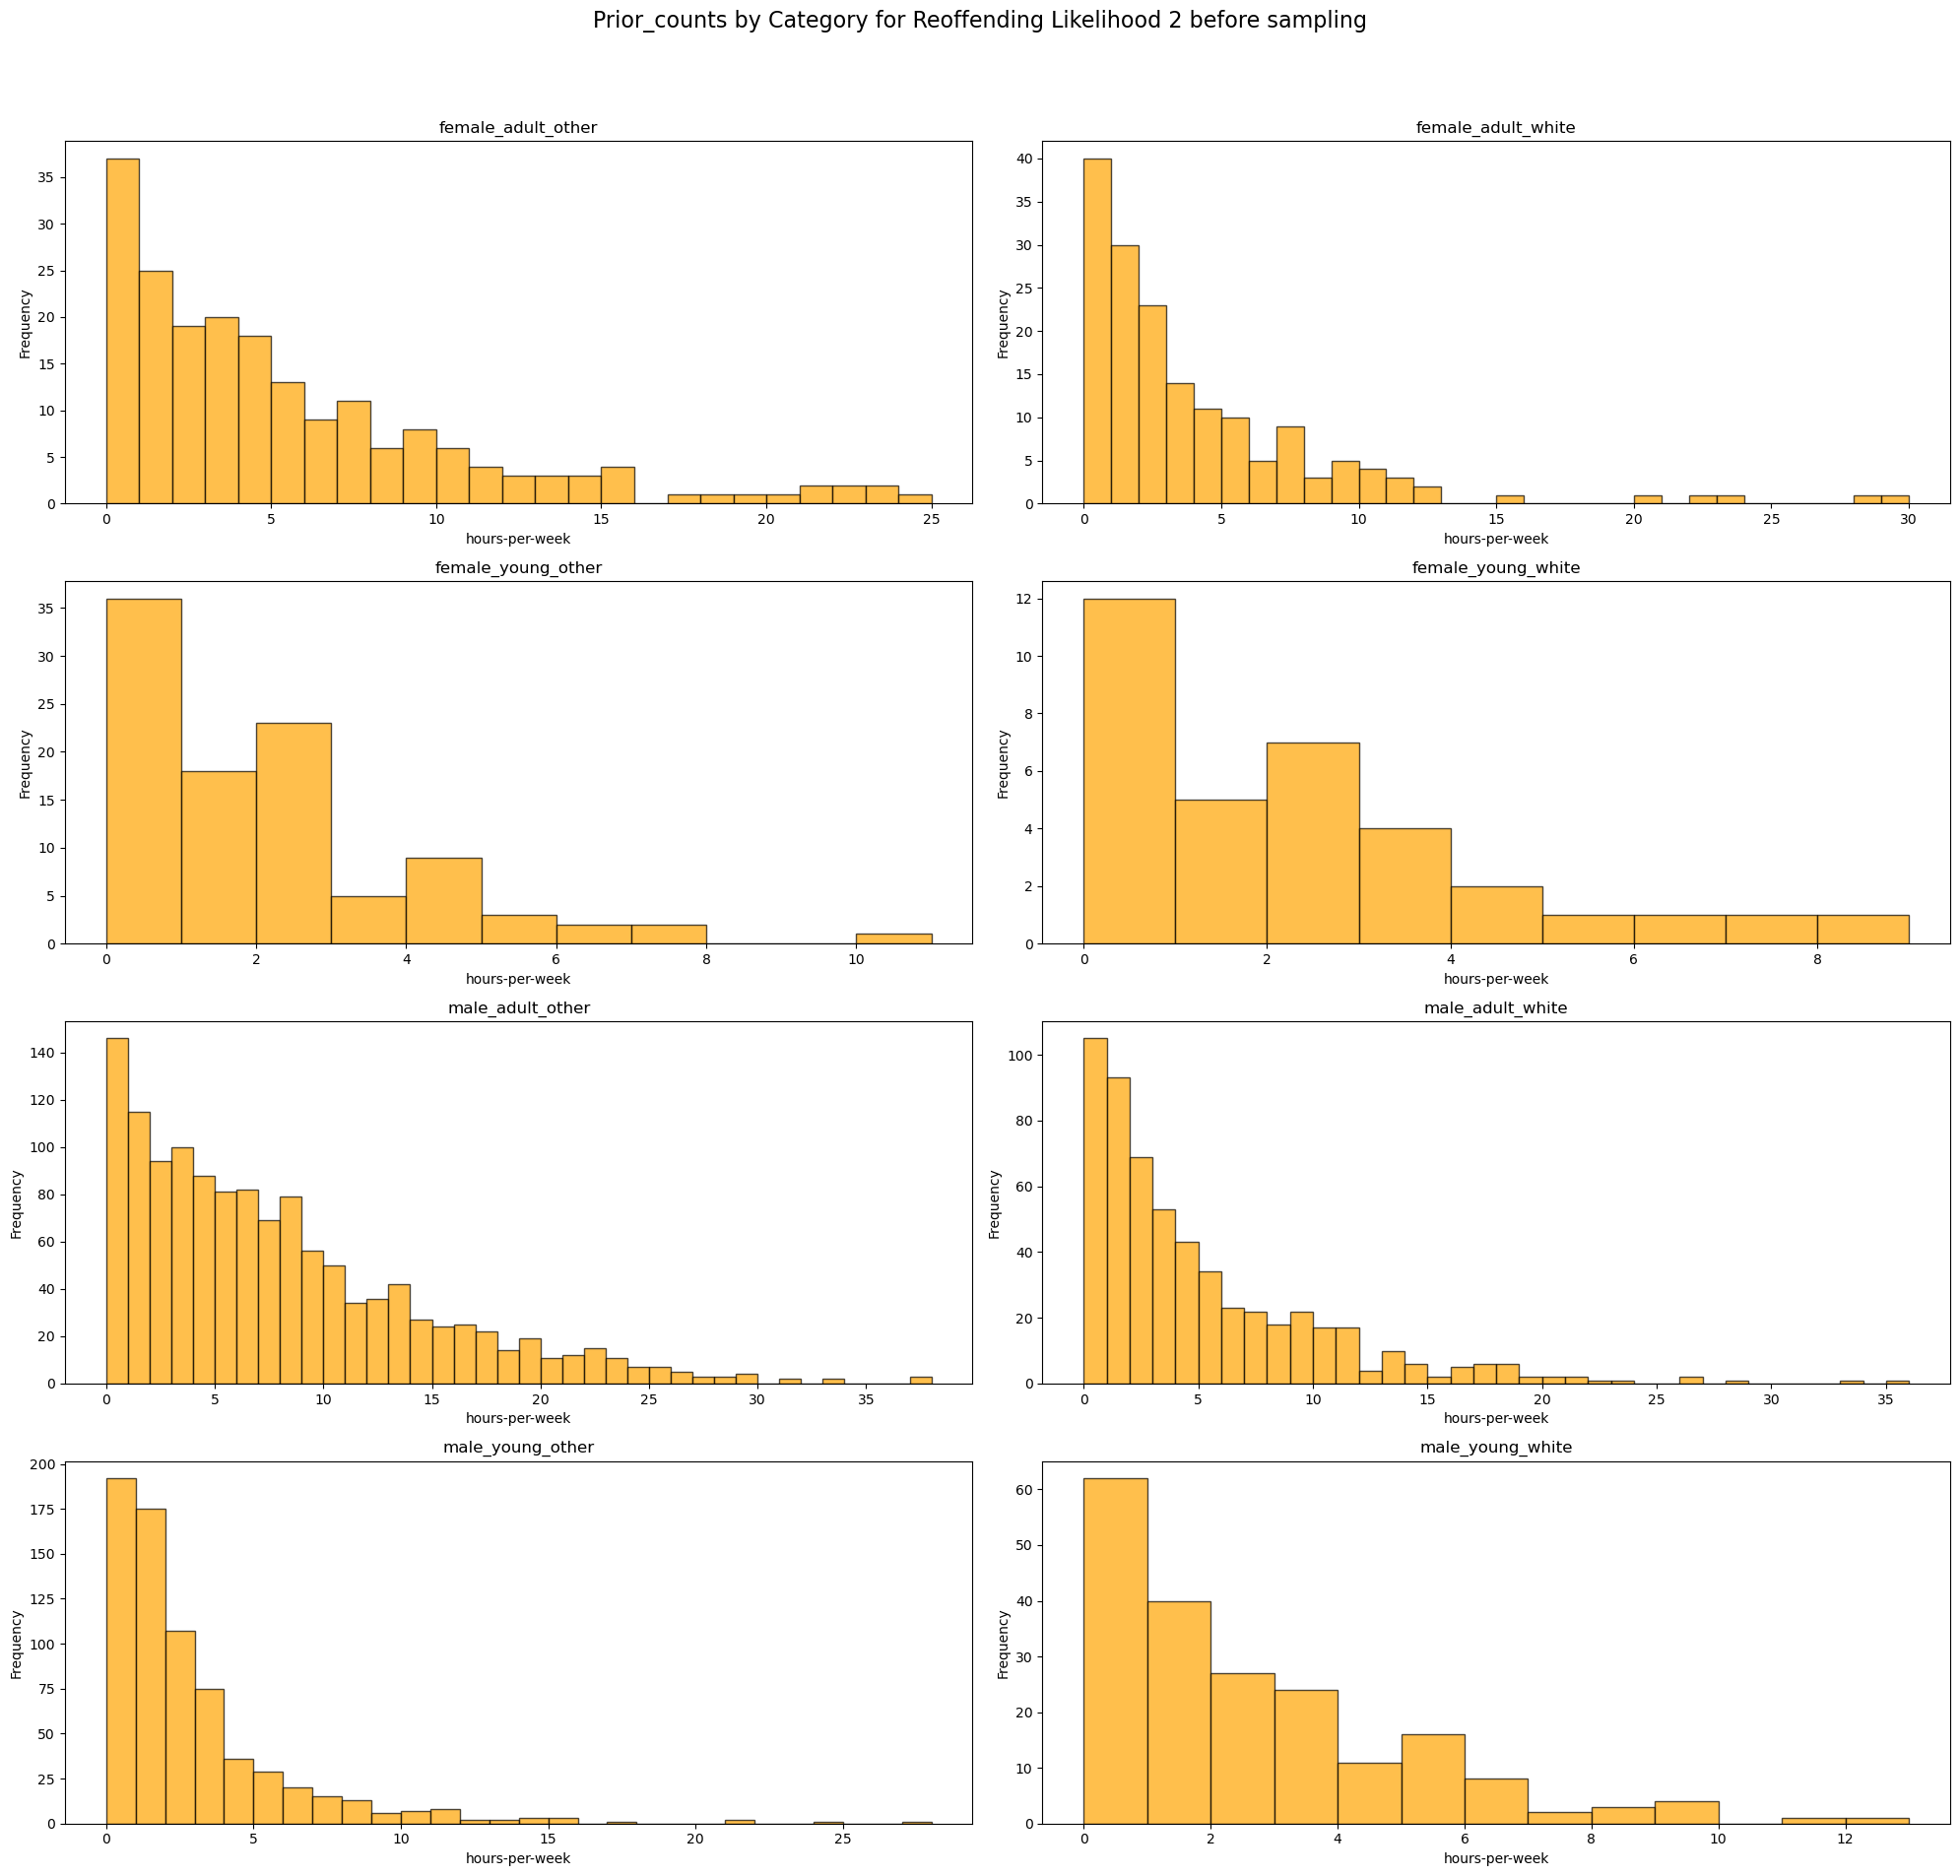

In [13]:
import matplotlib.pyplot as plt
# Prepare the dataset with the one-hot encoded features and necessary columns for plotting
plotting_data = data[['priors_count', 'Reoffending_Likelihood']].join(combined_one_hot_encoded)


# Set up the plotting environment for Class 1
plt.figure(figsize=(20, 20))
plt.suptitle('Prior_counts by Category for Reoffending Likelihood 1 before sampling', fontsize=16)

for i, column in enumerate(combined_one_hot_encoded.columns, start=1):
    plt.subplot(4, 2, i)  # Adjust layout for 8 plots in one figure
    filtered_data_class_1 = plotting_data[(plotting_data[column] == 1) & (plotting_data['Reoffending_Likelihood'] == 1)]
    plt.hist(filtered_data_class_1['priors_count'], bins=range(0, filtered_data_class_1['priors_count'].max() + 1), alpha=0.7, color='blue', edgecolor='black')
    plt.title(column)
    plt.xlabel('priors_count')
    plt.ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Set up the plotting environment for Class 2
plt.figure(figsize=(20, 20))
plt.suptitle('Prior_counts by Category for Reoffending Likelihood 2 before sampling', fontsize=16)

for i, column in enumerate(combined_one_hot_encoded.columns, start=1):
    plt.subplot(4, 2, i)  # Adjust layout for 8 plots in one figure
    filtered_data_class_2 = plotting_data[(plotting_data[column] == 1) & (plotting_data['Reoffending_Likelihood'] == 2)]
    plt.hist(filtered_data_class_2['priors_count'], bins=range(0, filtered_data_class_2['priors_count'].max() + 1), alpha=0.7, color='orange', edgecolor='black')
    plt.title(column)
    plt.xlabel('hours-per-week')
    plt.ylabel('Frequency')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import pandas as pd


# Placeholder feature and target columns
X = new_data.drop('Reoffending_Likelihood', axis=1)  
y = new_data['Reoffending_Likelihood'].replace({1: 0, 2: 1})

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Define preprocessing for numeric and categorical data
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'bool']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


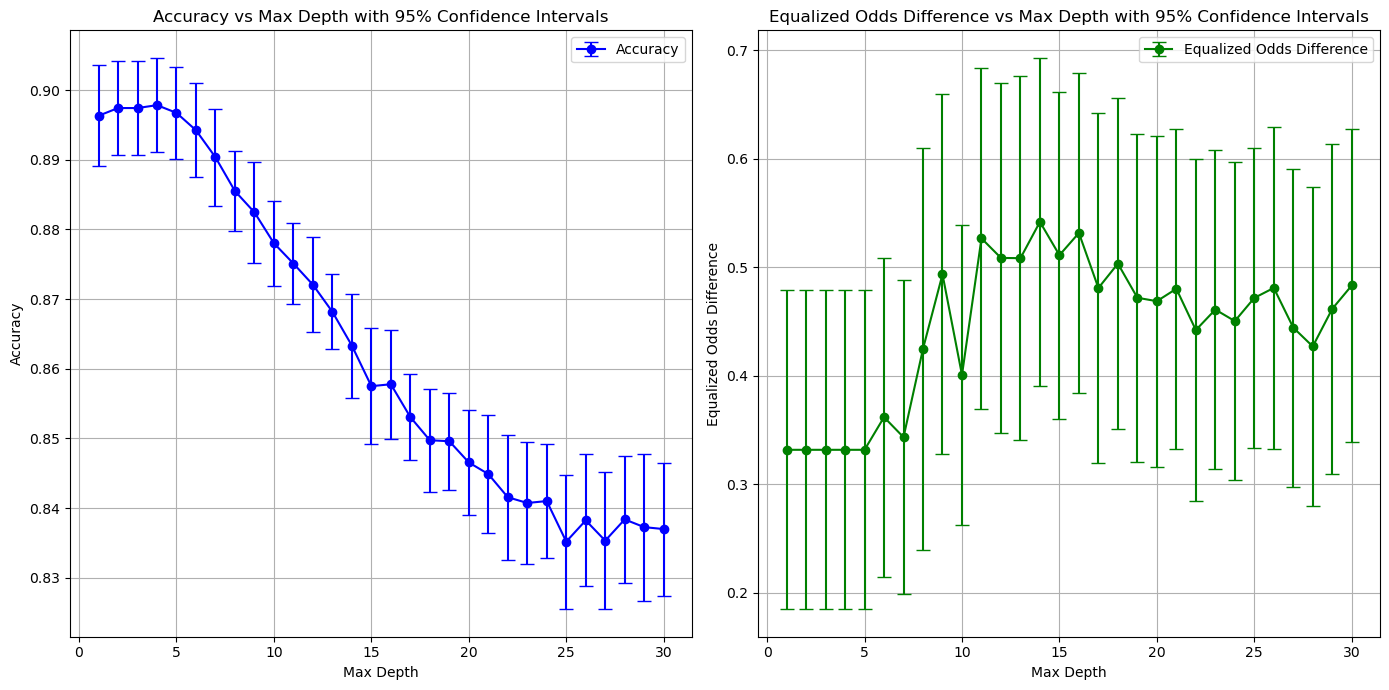

In [19]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
max_depth_range = range(1, 31)  # max_depth from 1 to 30
accuracies = {depth: [] for depth in max_depth_range}
eods = {depth: [] for depth in max_depth_range}

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    for depth in max_depth_range:
        clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        # Calculate accuracy
        acc = accuracy_score(y_test, y_pred)
        accuracies[depth].append(acc)

        # Calculate EOD
        mf = MetricFrame(metrics={'tpr': true_positive_rate, 'fpr': false_positive_rate},
                         y_true=y_test,
                         y_pred=y_pred,
                         sensitive_features=X_test[['female_adult_other', 'female_adult_white', 'female_young_other',
                             'female_young_white', 'male_adult_other', 'male_adult_white', 'male_young_other',
                             'male_young_white']])
        eod = max(mf.difference(method='between_groups')['tpr'], mf.difference(method='between_groups')['fpr'])
        eods[depth].append(eod)

# Calculate mean and confidence intervals for accuracies and eod
mean_accuracies = [np.mean(accuracies[depth]) for depth in max_depth_range]
sem_accuracies = [np.std(accuracies[depth]) / np.sqrt(len(accuracies[depth])) * 1.96 for depth in max_depth_range] 

mean_eods = [np.mean(eods[depth]) for depth in max_depth_range]
sem_eods = [np.std(eods[depth]) / np.sqrt(len(eods[depth])) * 1.96 for depth in max_depth_range]


plt.figure(figsize=(14, 7))

# Plot for Accuracy
plt.subplot(1, 2, 1)
plt.errorbar(max_depth_range, mean_accuracies, yerr=sem_accuracies, label='Accuracy', fmt='-o', capsize=5, color='blue')
plt.title('Accuracy vs Max Depth with 95% Confidence Intervals')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot for Equalized Odds Difference
plt.subplot(1, 2, 2)
plt.errorbar(max_depth_range, mean_eods, yerr=sem_eods, label='Equalized Odds Difference', fmt='-o', capsize=5, color='green')
plt.title('Equalized Odds Difference vs Max Depth with 95% Confidence Intervals')
plt.xlabel('Max Depth')
plt.ylabel('Equalized Odds Difference')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



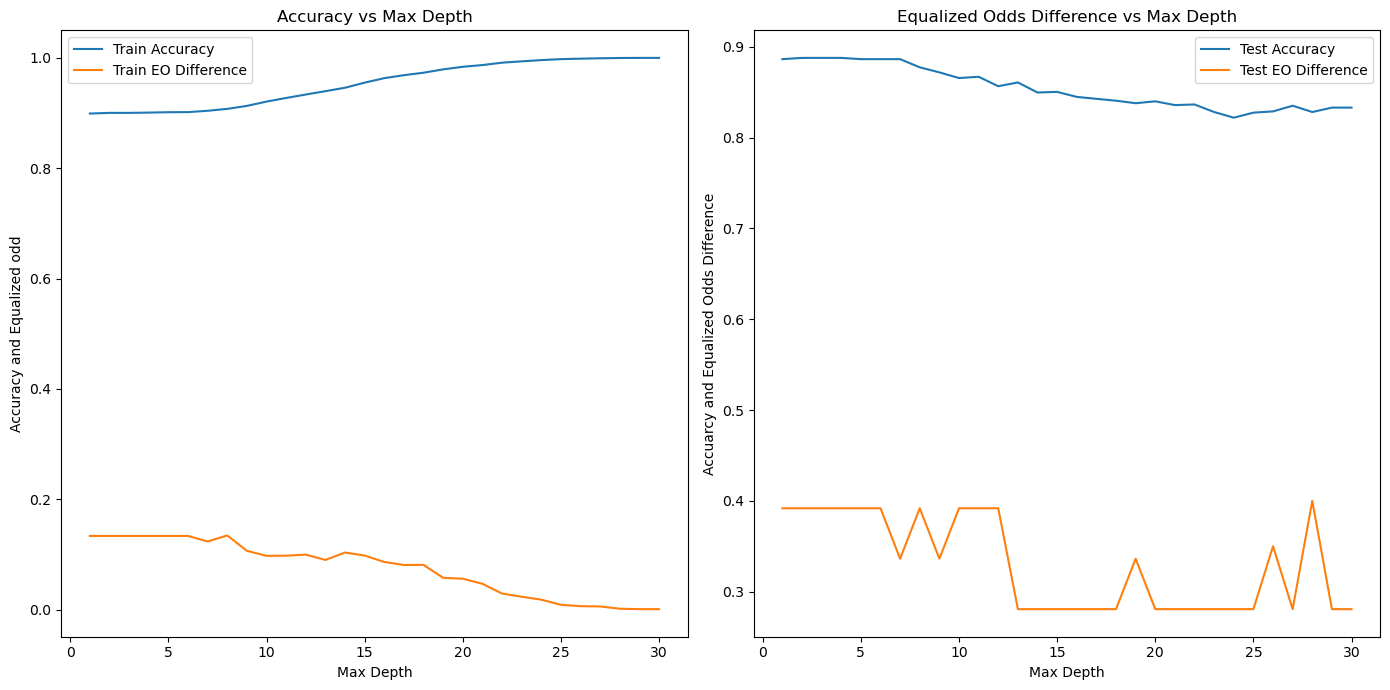

In [20]:
X = new_data.drop('Reoffending_Likelihood', axis=1)  
y = new_data['Reoffending_Likelihood'].replace({1: 0, 2: 1})


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def compute_eod_and_accuracy(clf, X, y, sensitive_attr):
    predictions = clf.predict(X)
    accuracy = accuracy_score(y, predictions)

    # Calculate Equalized Odds Difference using Fairlearn's MetricFrame
    mf = MetricFrame(metrics={
                        'tpr': true_positive_rate, 
                        'fpr': false_positive_rate
                     },
                     y_true=y, 
                     y_pred=predictions, 
                     sensitive_features=sensitive_attr.idxmax(axis=1))
    
    eo_diff = max(mf.difference(method='between_groups')['tpr'], 
                  mf.difference(method='between_groups')['fpr'])
    
    return accuracy, eo_diff

max_depths = range(1, 31)
train_accuracies = []
test_accuracies = []
train_eods = []
test_eods = []

# Ensure sensitive_attr is correctly formatted before looping
sensitive_attr_train = X_train[['female_adult_other', 'female_adult_white', 'female_young_other',
                             'female_young_white', 'male_adult_other', 'male_adult_white', 'male_young_other',
                             'male_young_white']]
sensitive_attr_test = X_test[['female_adult_other', 'female_adult_white', 'female_young_other',
                             'female_young_white', 'male_adult_other', 'male_adult_white', 'male_young_other',
                             'male_young_white']]

for depth in max_depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)

    # Compute metrics for training data
    train_accuracy, train_eod = compute_eod_and_accuracy(clf, X_train, y_train, sensitive_attr_train)
    train_accuracies.append(train_accuracy)
    train_eods.append(train_eod)

    # Compute metrics for testing data
    test_accuracy, test_eod = compute_eod_and_accuracy(clf, X_test, y_test, sensitive_attr_test)
    test_accuracies.append(test_accuracy)
    test_eods.append(test_eod)

    
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(max_depths, train_accuracies, label='Train Accuracy')
plt.plot(max_depths, train_eods, label='Train EO Difference')
plt.title('Accuracy vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy and Equalized odd')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(max_depths, test_accuracies, label='Test Accuracy')
plt.plot(max_depths, test_eods, label='Test EO Difference')
plt.title('Equalized Odds Difference vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuarcy and Equalized Odds Difference')
plt.legend()

plt.tight_layout()
plt.show()



0.8877338877338877


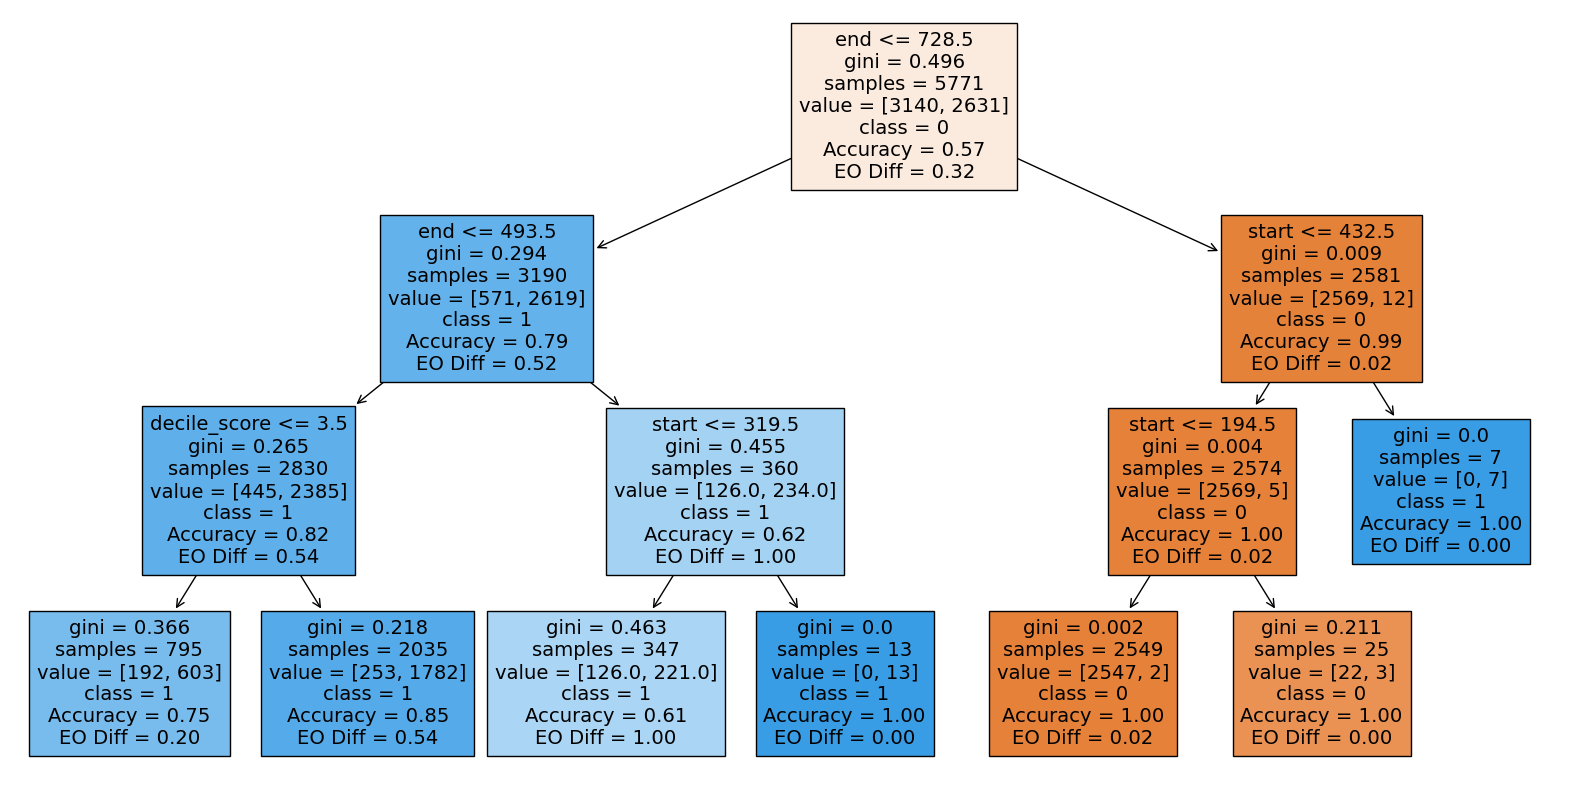

0.9001906082134812
              precision    recall  f1-score   support

           0       1.00      0.81      0.89       823
           1       0.79      1.00      0.88       620

    accuracy                           0.89      1443
   macro avg       0.90      0.90      0.89      1443
weighted avg       0.91      0.89      0.89      1443



In [22]:

clf = DecisionTreeClassifier(criterion='gini',max_depth=3,random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

def compute_node_eod(tree, X, y, sensitive_attr):
    accuracies = np.zeros(tree.tree_.node_count)
    eo_diff = np.zeros(tree.tree_.node_count) 
    
    node_indicator = tree.decision_path(X)
    
    for node_id in range(tree.tree_.node_count):
        node_samples = node_indicator[:, node_id].toarray().ravel().astype(bool)
        if not any(node_samples):
            continue  

        node_labels = y[node_samples]
        node_sensitive = sensitive_attr[node_samples]
        
        # Most common label predicted at this node
        most_common = np.argmax(tree.tree_.value[node_id])
        predictions = np.full(len(node_labels), most_common)
        
        accuracies[node_id] = np.mean(predictions == node_labels)
        
        mf = MetricFrame(
            metrics={
                'tpr': true_positive_rate,
                'fpr': false_positive_rate,
                'accuracy': accuracy_score,
                
            },
            y_true=node_labels,
            y_pred=predictions,
            sensitive_features=node_sensitive
        )
        
        tpr_diff = mf.difference(method='between_groups')
        fpr_diff = mf.difference(method='between_groups')
        eo_diff[node_id] = max(tpr_diff.max(), fpr_diff.max())  # Maximum difference for EO
        
        #eo_diff[node_id] =  equalized_odds_difference(y_true=y_test, y_pred=y_predic,
                                                      #sensitive_features=sensitive_attr)
    return accuracies, eo_diff


# Assuming sensitive_attr is part of your DataFrame
sensitive_attr = X_test[['female_adult_other', 'female_adult_white', 'female_young_other',
                             'female_young_white', 'male_adult_other', 'male_adult_white', 'male_young_other',
                             'male_young_white']]

node_accuracies, node_eod = compute_node_eod(clf, X_test, y_test, sensitive_attr)

fig, ax = plt.subplots(figsize=(20, 10))
tree_plot = plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=["0", "1"], ax=ax)

# Annotating with accuracies and EO difference
for i, text in enumerate(tree_plot):
    if i < len(node_accuracies):  
        metrics_text = f'\nAccuracy = {node_accuracies[i]:.2f}'
        metrics_text += f'\nEO Diff = {node_eod[i]:.2f}'
        text.set_text(text.get_text() + metrics_text)

plt.show()

y_new = clf.predict(X_train)
print(accuracy_score(y_new, y_train))
print(classification_report(y_test, y_pred))

In [25]:
from fairlearn.metrics import MetricFrame, equalized_odds_difference
from sklearn.metrics import recall_score

sensitive_features = X_test[['female_adult_other', 'female_adult_white', 'female_young_other',
                             'female_young_white', 'male_adult_other', 'male_adult_white', 'male_young_other',
                             'male_young_white']]
sensitive_feature_single = sensitive_features.idxmax(axis=1)

# Define the metric you want to evaluate (True Positive Rate here as an example)
def true_positive_rate(y_true, y_pred):
    return recall_score(y_true, y_pred)

# Create a MetricFrame for Equalized Odds Difference calculation using the corrected sensitive_features reference


mf_dt = MetricFrame(metrics=true_positive_rate,
                    y_true=y_test,
                    y_pred=y_pred,
                    sensitive_features=sensitive_feature_single)  # Use the variable directly

# Calculate Equalized Odds Difference using the corrected sensitive_features reference
#eod_lr = equalized_odds_difference(y_true=y_test, y_pred=lr_preds, sensitive_features=sensitive_feature_single)
eod_dt = equalized_odds_difference(y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_feature_single)

#print(f"Equalized Odds Difference for Logistic Regression: {eod_lr}")
print(f"Equalized Odds Difference for Decision Tree: {eod_dt}")


print("\nMetric Frame for Decision Tree:")
print(mf_dt.by_group)




Equalized Odds Difference for Decision Tree: 0.391812865497076

Metric Frame for Decision Tree:
sensitive_feature_0
female_adult_other    0.969697
female_adult_white    1.000000
female_young_other    1.000000
female_young_white    1.000000
male_adult_other      0.996094
male_adult_white      1.000000
male_young_other      1.000000
male_young_white      1.000000
Name: true_positive_rate, dtype: float64


In [29]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score

sensitive_features = X_test[['female_adult_other', 'female_adult_white', 'female_young_other',
                             'female_young_white', 'male_adult_other', 'male_adult_white', 'male_young_other',
                             'male_young_white']]
sensitive_feature_single = sensitive_features.idxmax(axis=1)

# Define a metric to evaluate the positive prediction rate
def positive_prediction_rate(y_true, y_pred):
    
    return np.mean(y_pred)


mf_dt_stat_parity = MetricFrame(metrics=positive_prediction_rate,
                                y_true=y_test,  # This is also necessary but not used
                                y_pred=y_pred,
                                sensitive_features=sensitive_feature_single)

# The difference in positive prediction rates between the most and least favored groups can serve as a measure of statistical parity
#diff_lr_stat_parity = mf_lr_stat_parity.difference(method='between_groups')
diff_dt_stat_parity = mf_dt_stat_parity.difference(method='between_groups')

#print(f"Difference in Positive Prediction Rates for Logistic Regression (Statistical Parity): {diff_lr_stat_parity}")
print(f"Difference in Positive Prediction Rates for Decision Tree (Statistical Parity): {diff_dt_stat_parity}")

# Additionally, to see the breakdown by group
#print("\nPositive Prediction Rate by Group for Logistic Regression:")
#print(mf_lr_stat_parity.by_group)

print("\nPositive Prediction Rate by Group for Decision Tree:")
print(mf_dt_stat_parity.by_group)


Difference in Positive Prediction Rates for Decision Tree (Statistical Parity): 0.28504273504273503

Positive Prediction Rate by Group for Decision Tree:
sensitive_feature_0
female_adult_other    0.403846
female_adult_white    0.445783
female_young_other    0.538462
female_young_white    0.583333
male_adult_other      0.557895
male_adult_white      0.436533
male_young_other      0.688889
male_young_white      0.666667
Name: positive_prediction_rate, dtype: float64


Proportional Sampling

In [33]:
#oversampling of class 2
data_class_1 = data[data['Reoffending_Likelihood'] == 1]
data_class_2 = data[data['Reoffending_Likelihood'] == 2]


data_class_2_oversampled = resample(data_class_2,
                                    replace=True, n_samples=len(data_class_1), 
                                    random_state=123) 

balanced_data = pd.concat([data_class_1, data_class_2_oversampled])


balanced_class_distribution = balanced_data['Reoffending_Likelihood'].value_counts()
balanced_class_distribution

Reoffending_Likelihood
1    3963
2    3963
Name: count, dtype: int64

In [34]:
combined_columns_balanced = balanced_data['sex'] + "_" + balanced_data['Age_class'] + "_" + balanced_data['race_class']
one_hot_encoded_balanced = pd.get_dummies(combined_columns_balanced)


column_sums_balanced = one_hot_encoded_balanced.sum()
print(column_sums_balanced)
sampled_balanced_df = pd.DataFrame()

balanced_data.reset_index(drop=True, inplace=True)
one_hot_encoded_balanced.reset_index(drop=True, inplace=True)
balanced_data_old = pd.concat([balanced_data, one_hot_encoded_balanced], axis=1)
categorical_features = balanced_data_old.select_dtypes(include=['object', 'bool'])
for col in categorical_features:
    le = LabelEncoder()
    balanced_data_old[col] = balanced_data_old[col].fillna('missing')
    balanced_data_old[col] = le.fit_transform(balanced_data_old[col])
    
balanced_data_old = balanced_data_old.drop(['Age_class', 'sex', 'age', 'race_class'], axis = 1) 
X = balanced_data_old.drop('Reoffending_Likelihood', axis=1)
y= balanced_data_old['Reoffending_Likelihood'].replace({1:0, 2:1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42, stratify=y)
balanced_data_with_one_hot = pd.concat([X_train, y_train], axis=1)

target_samples = 5000

# Iterate over each one-hot encoded column to sample with replacement
for column in one_hot_encoded_balanced.columns:
    # Filter rows where the category is indicated
    category_rows = balanced_data_with_one_hot[balanced_data_with_one_hot[column] == 1]
    
    # Sample with replacement from these rows to reach the target count
    sampled_rows = category_rows.sample(n=target_samples, replace=True, random_state=123)
    
    # Since we're sampling per category, each set of sampled rows will have the category set to 1 and the rest to 0
    # Reset the one-hot encoded columns to reflect only the current category
    for col in one_hot_encoded_balanced.columns:
        sampled_rows[col] = 0
    sampled_rows[column] = 1
    
    # Append the sampled rows to the new DataFrame
    sampled_balanced_df = pd.concat([sampled_balanced_df, sampled_rows])

final_sampled_counts = sampled_balanced_df[one_hot_encoded_balanced.columns].sum()

#print(sampled_balanced_df)
print(final_sampled_counts)



Female_Adult_Other     622
Female_Adult_White     495
Female_Young_Other     240
Female_Young_White     120
Male_Adult_Other      3080
Male_Adult_White      1662
Male_Young_Other      1275
Male_Young_White       432
dtype: int64
Female_Adult_Other    5000
Female_Adult_White    5000
Female_Young_Other    5000
Female_Young_White    5000
Male_Adult_Other      5000
Male_Adult_White      5000
Male_Young_Other      5000
Male_Young_White      5000
dtype: int64


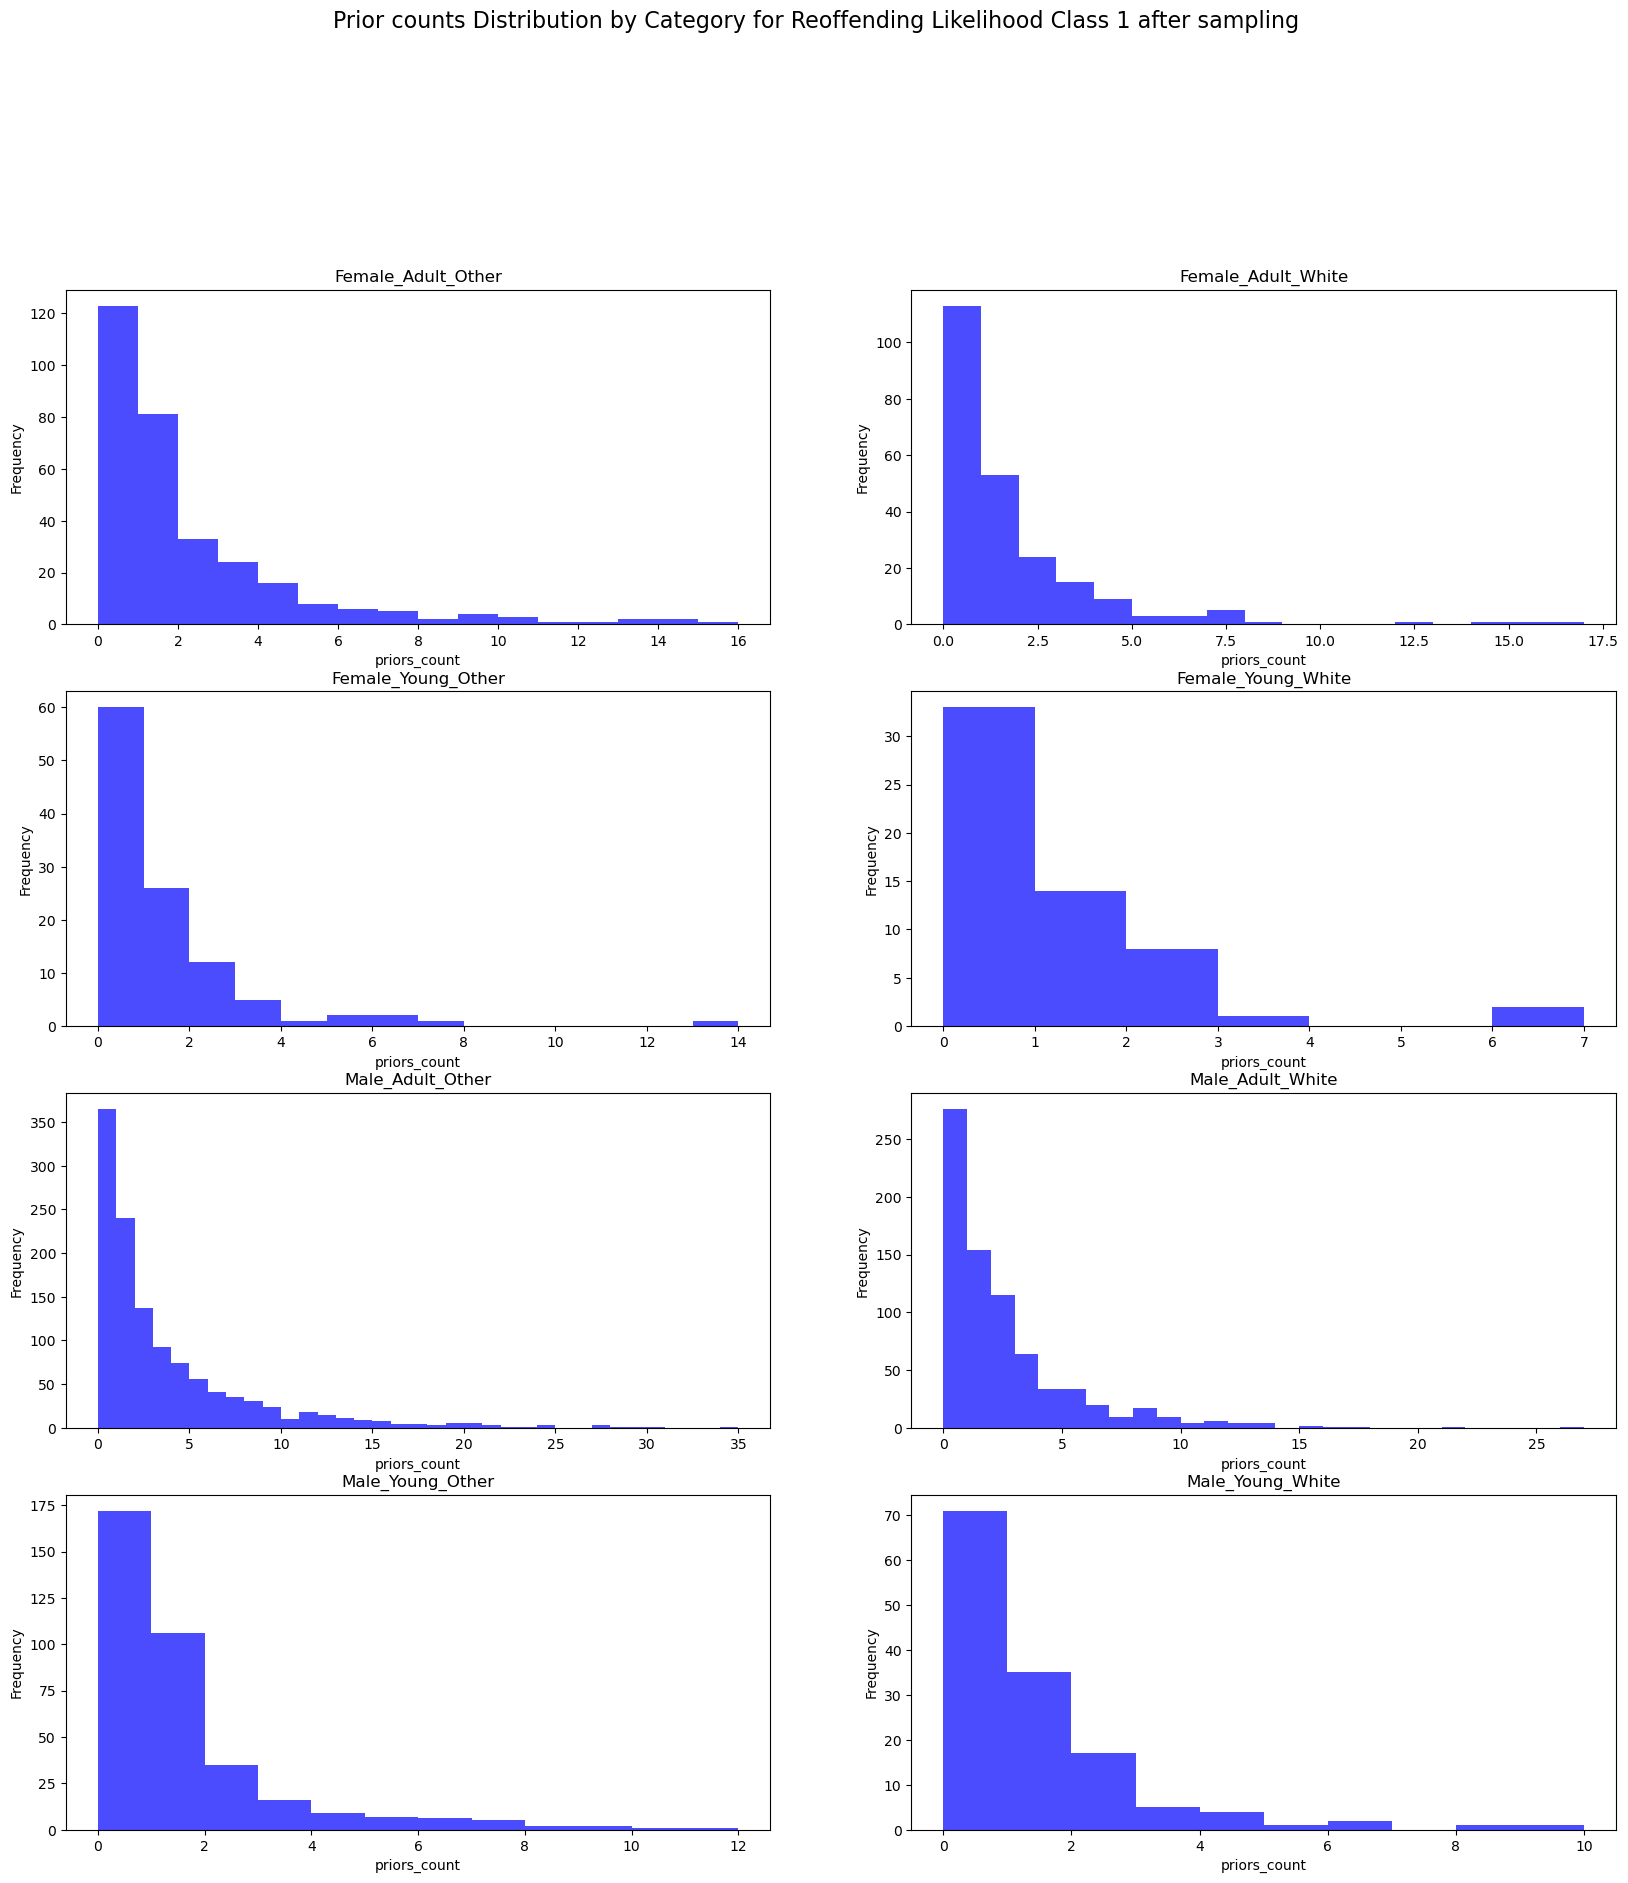

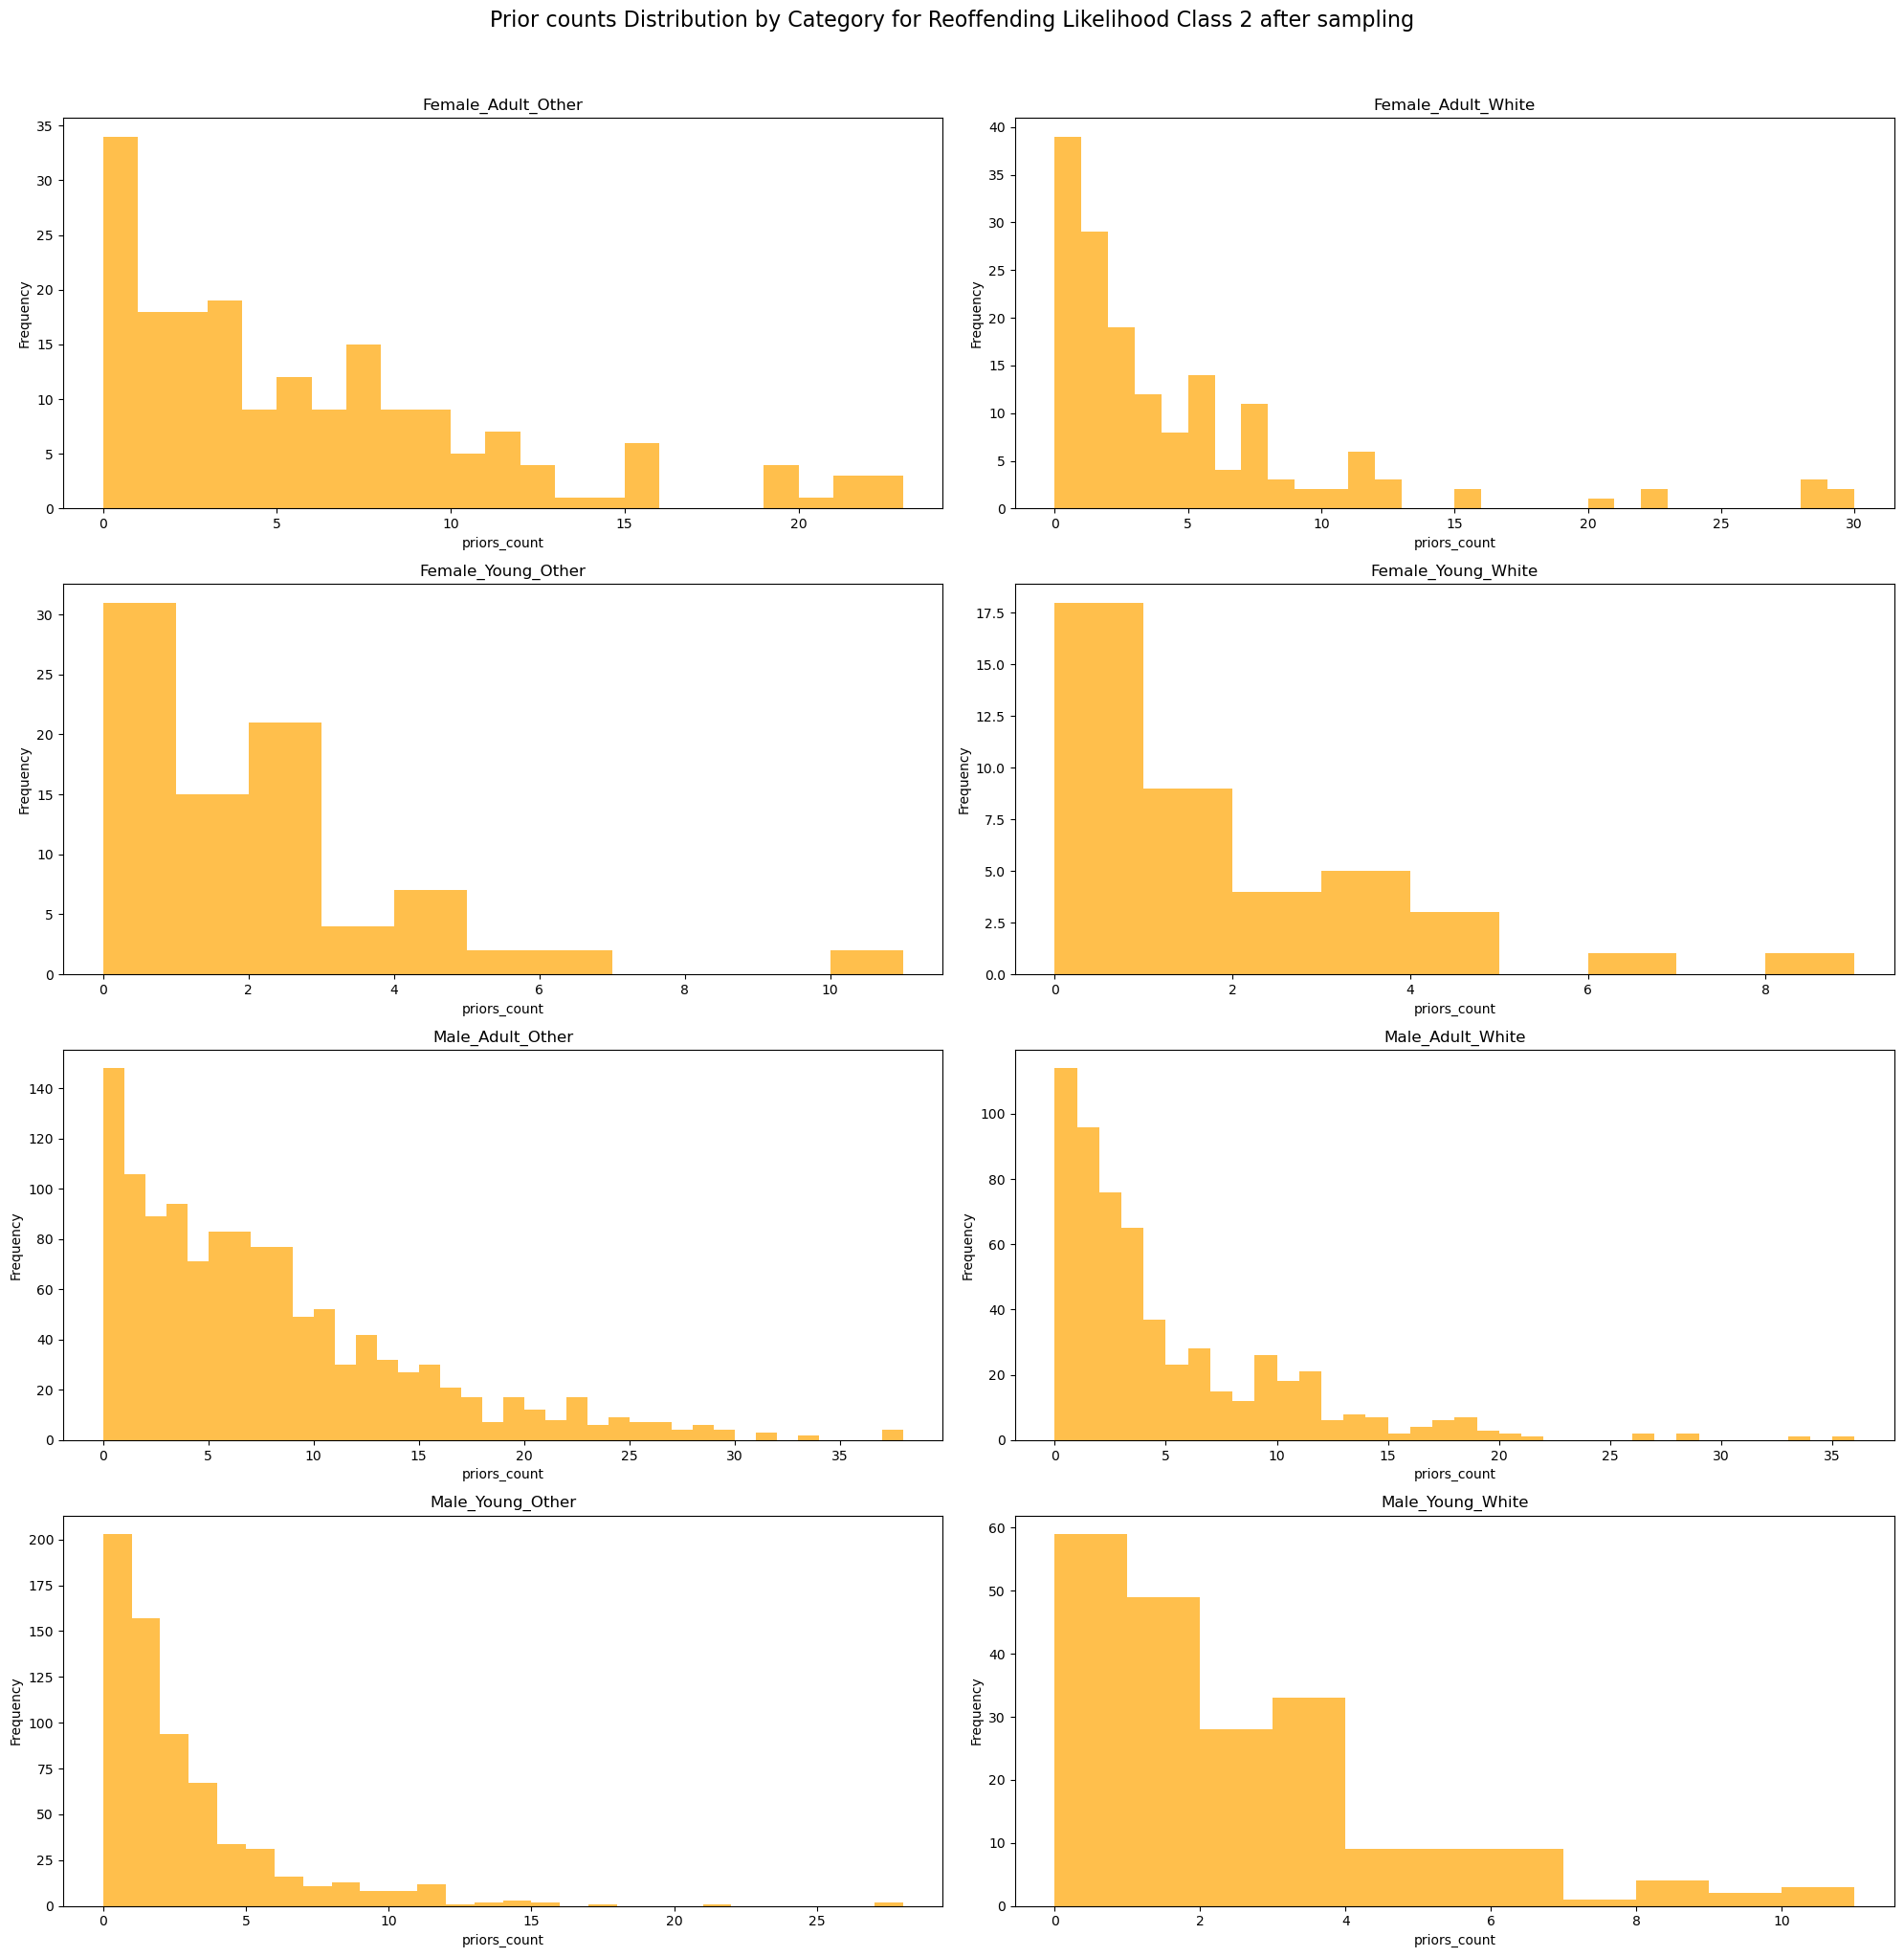

In [38]:
import matplotlib.pyplot as plt

# Define the layout for your subplots
plot_rows = 4  # Number of rows in the subplot grid
plot_cols = 2  # Number of columns in the subplot grid

# Set up the plotting environment for Class 1
plt.figure(figsize=(20, 20))
plt.suptitle('Prior counts Distribution by Category for Reoffending Likelihood Class 1 after sampling', fontsize=16, y=1.02)

# Plot for Class 1
for i, column in enumerate(one_hot_encoded_balanced.columns, start=1): 
    plt.subplot(plot_rows, plot_cols, i)
    # Filter data for the current category, for class 1
    category_class_1 = balanced_data_with_one_hot[(balanced_data_with_one_hot[column] == 1) & (balanced_data_with_one_hot['Reoffending_Likelihood'] == 0)]
    # Plot histograms for class 1
    plt.hist(category_class_1['priors_count'], bins=range(0, category_class_1['priors_count'].max() + 1), alpha=0.7, color='blue')
    # Title and labels
    plt.title(column)
    plt.xlabel('priors_count')
    plt.ylabel('Frequency')

# Repeat for Class 2 in a new figure
plt.figure(figsize=(20, 20))
plt.suptitle('Prior counts Distribution by Category for Reoffending Likelihood Class 2 after sampling', fontsize=16, y=1.02)

# Plot for Class 2
for i, column in enumerate(one_hot_encoded_balanced.columns, start=1):  # Adjusted to include only the one-hot encoded columns
    plt.subplot(plot_rows, plot_cols, i)
    # Filter data for the current category, for class 2
    category_class_2 = balanced_data_with_one_hot[(balanced_data_with_one_hot[column] == 1) & (balanced_data_with_one_hot['Reoffending_Likelihood'] == 1)]
    # Plot histograms for class 2
    plt.hist(category_class_2['priors_count'], bins=range(0, category_class_2['priors_count'].max() + 1), alpha=0.7, color='orange')
    # Title and labels
    plt.title(column)
    plt.xlabel('priors_count')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [39]:
X_train = sampled_balanced_df.drop(['Reoffending_Likelihood'], axis=1)  
y_train = sampled_balanced_df['Reoffending_Likelihood']


# Define preprocessing for numeric and categorical data
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


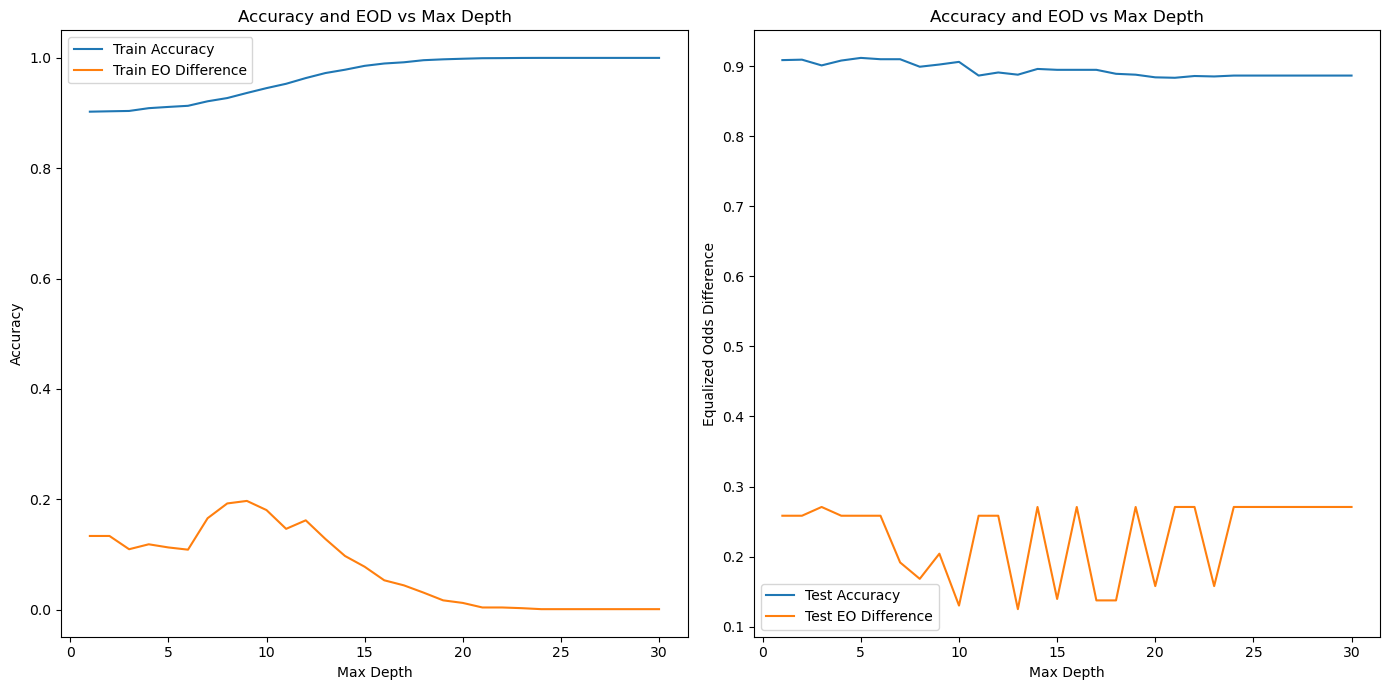

In [40]:

def compute_eod_and_accuracy(clf, X, y, sensitive_attr):
    predictions = clf.predict(X)
    accuracy = accuracy_score(y, predictions)

    # Calculate Equalized Odds Difference using Fairlearn's MetricFrame
    mf = MetricFrame(metrics={
                        'tpr': true_positive_rate, 
                        'fpr': false_positive_rate,
                        'accuracy': accuracy_score
                     },
                     y_true=y, 
                     y_pred=predictions, 
                     sensitive_features=sensitive_attr.idxmax(axis=1))
    
    eo_diff = max(mf.difference(method='between_groups')['tpr'], 
                  mf.difference(method='between_groups')['fpr'])
    
    return accuracy, eo_diff

max_depths = range(1, 31)
train_accuracies = []
test_accuracies = []
train_eods = []
test_eods = []

# Ensure sensitive_attr is correctly formatted before looping
sensitive_attr_train = X_train[['Female_Adult_Other', 'Female_Adult_White', 'Female_Young_Other',
                             'Female_Young_White', 'Male_Adult_Other', 'Male_Adult_White', 'Male_Young_Other',
                             'Male_Young_White']]
sensitive_attr_test = X_test[['Female_Adult_Other', 'Female_Adult_White', 'Female_Young_Other',
                             'Female_Young_White', 'Male_Adult_Other', 'Male_Adult_White', 'Male_Young_Other',
                             'Male_Young_White']]

for depth in max_depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)

    # Compute metrics for training data
    train_accuracy, train_eod = compute_eod_and_accuracy(clf, X_train, y_train, sensitive_attr_train)
    train_accuracies.append(train_accuracy)
    train_eods.append(train_eod)

    # Compute metrics for testing data
    test_accuracy, test_eod = compute_eod_and_accuracy(clf, X_test, y_test, sensitive_attr_test)
    test_accuracies.append(test_accuracy)
    test_eods.append(test_eod)

    
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(max_depths, train_accuracies, label='Train Accuracy')
plt.plot(max_depths, train_eods, label='Train EO Difference')
plt.title('Accuracy and EOD vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(max_depths, test_accuracies, label='Test Accuracy')
plt.plot(max_depths, test_eods, label='Test EO Difference')
plt.title('Accuracy and EOD vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Equalized Odds Difference')
plt.legend()

plt.tight_layout()
plt.show()



0.9010088272383354


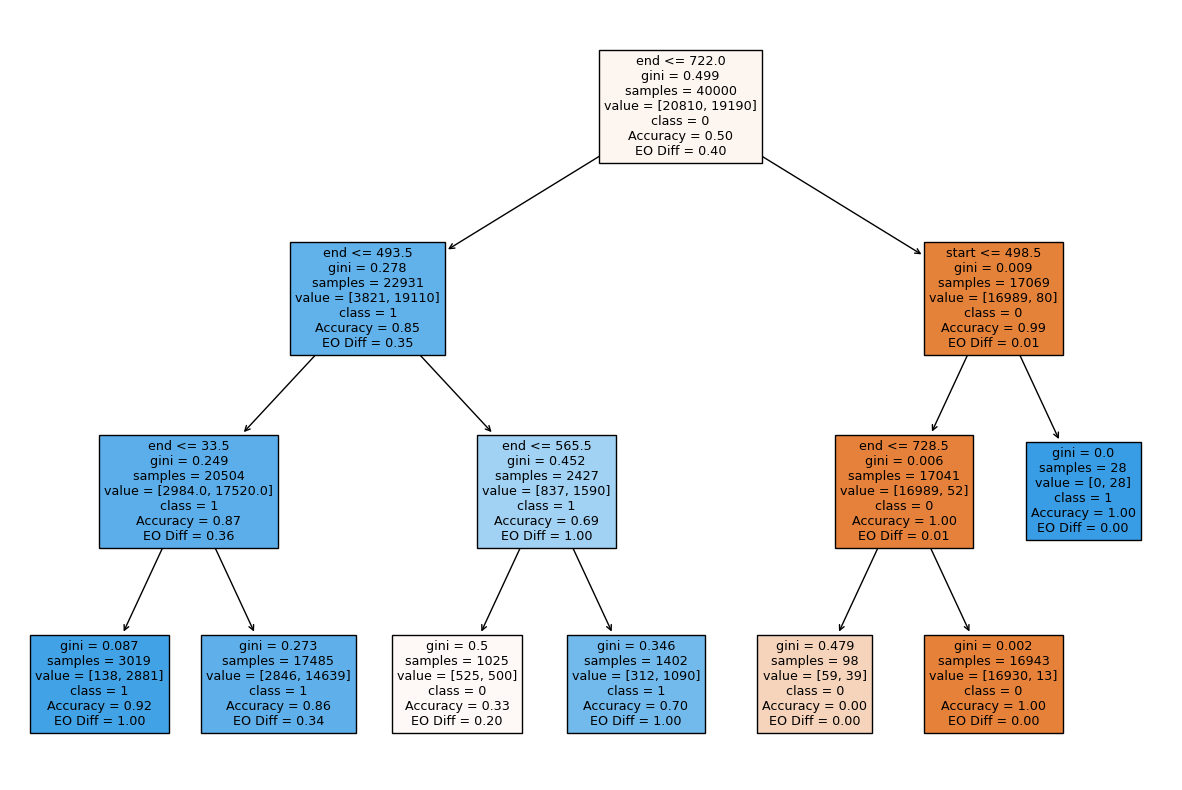

0.9038
              precision    recall  f1-score   support

           0       0.96      0.84      0.89       793
           1       0.86      0.96      0.91       793

    accuracy                           0.90      1586
   macro avg       0.91      0.90      0.90      1586
weighted avg       0.91      0.90      0.90      1586



In [42]:
import warnings
warnings.filterwarnings('ignore')
clf = DecisionTreeClassifier(criterion='gini',max_depth=3,random_state=42)
clf.fit(X_train, y_train)
y_predic = clf.predict(X_test)
print(accuracy_score(y_test, y_predic))

def compute_node_eod(tree, X, y, sensitive_attr):
    accuracies = np.zeros(tree.tree_.node_count)
    eo_diff = np.zeros(tree.tree_.node_count) 
    
    node_indicator = tree.decision_path(X)
    
    for node_id in range(tree.tree_.node_count):
        node_samples = node_indicator[:, node_id].toarray().ravel().astype(bool)
        if not any(node_samples):
            continue  

        node_labels = y[node_samples]
        node_sensitive = sensitive_attr[node_samples]
        
        # Most common label predicted at this node
        most_common = np.argmax(tree.tree_.value[node_id])
        predictions = np.full(len(node_labels), most_common)
        
        accuracies[node_id] = np.mean(predictions == node_labels)
        
        mf = MetricFrame(
            metrics={
                'tpr': true_positive_rate,
                'fpr': false_positive_rate,
                'accuracy': accuracy_score
            },
            y_true=node_labels,
            y_pred=predictions,
            sensitive_features=node_sensitive
        )
        
        tpr_diff = mf.difference(method='between_groups')
        fpr_diff = mf.difference(method='between_groups')
        eo_diff[node_id] = max(tpr_diff.max(), fpr_diff.max())  # Maximum difference for EO
        
        #eo_diff[node_id] =  equalized_odds_difference(y_true=y_test, y_pred=y_predic,
                                                      #sensitive_features=sensitive_attr)
    return accuracies, eo_diff


# Assuming sensitive_attr is part of your DataFrame
sensitive_attr = X_test[['Female_Adult_Other', 'Female_Adult_White', 'Female_Young_Other',
                             'Female_Young_White', 'Male_Adult_Other', 'Male_Adult_White', 'Male_Young_Other',
                             'Male_Young_White']]

node_accuracies, node_eod = compute_node_eod(clf, X_test, y_test, sensitive_attr)

fig, ax = plt.subplots(figsize=(15, 10))
tree_plot = plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=["0", "1"], ax=ax)

# Annotating with accuracies and EO difference
for i, text in enumerate(tree_plot):
    if i < len(node_accuracies):  
        metrics_text = f'\nAccuracy = {node_accuracies[i]:.2f}'
        metrics_text += f'\nEO Diff = {node_eod[i]:.2f}'
        text.set_text(text.get_text() + metrics_text)

plt.show()

y_new = clf.predict(X_train)
print(accuracy_score(y_new, y_train))
print(classification_report(y_test, y_predic))

In [43]:
from fairlearn.metrics import MetricFrame, equalized_odds_difference
from sklearn.metrics import recall_score

sensitive_features = X_test[['Female_Adult_Other', 'Female_Adult_White', 'Female_Young_Other',
                             'Female_Young_White', 'Male_Adult_Other', 'Male_Adult_White', 'Male_Young_Other',
                             'Male_Young_White']]
sensitive_feature_single = sensitive_features.idxmax(axis=1)

def true_positive_rate(y_true, y_pred):
    return recall_score(y_true, y_pred)

 

mf_dt = MetricFrame(metrics=true_positive_rate,
                    y_true=y_test,
                    y_pred=y_predic,
                    sensitive_features=sensitive_feature_single)  

# Calculate Equalized Odds Difference using the corrected sensitive_features reference
#eod_lr = equalized_odds_difference(y_true=y_test, y_pred=lr_preds, sensitive_features=sensitive_feature_single)
eod_dt = equalized_odds_difference(y_true=y_test, y_pred=y_predic, sensitive_features=sensitive_feature_single)

#print(f"Equalized Odds Difference for Logistic Regression: {eod_lr}")
print(f"Equalized Odds Difference for Decision Tree: {eod_dt}")

print("\nMetric Frame for Decision Tree:")
print(mf_dt.by_group)

Equalized Odds Difference for Decision Tree: 0.2708333333333333

Metric Frame for Decision Tree:
sensitive_feature_0
Female_Adult_Other    0.953488
Female_Adult_White    0.947368
Female_Young_Other    1.000000
Female_Young_White    1.000000
Male_Adult_Other      0.960961
Male_Adult_White      0.971429
Male_Young_Other      0.958580
Male_Young_White      0.977778
Name: true_positive_rate, dtype: float64


In [44]:


sensitive_features = X_test[['Female_Adult_Other', 'Female_Adult_White', 'Female_Young_Other',
                             'Female_Young_White', 'Male_Adult_Other', 'Male_Adult_White', 'Male_Young_Other',
                             'Male_Young_White']]
sensitive_feature_single = sensitive_features.idxmax(axis=1)

# Define a metric to evaluate the positive prediction rate
def positive_prediction_rate(y_true, y_pred):
    
    return np.mean(y_pred)



mf_dt_stat_parity = MetricFrame(metrics=positive_prediction_rate,
                                y_true=y_test,  # This is also necessary but not used
                                y_pred=y_predic,
                                sensitive_features=sensitive_feature_single)

# The difference in positive prediction rates between the most and least favored groups can serve as a measure of statistical parity
#diff_lr_stat_parity = mf_lr_stat_parity.difference(method='between_groups')
diff_dt_stat_parity = mf_dt_stat_parity.difference(method='between_groups')

#print(f"Difference in Positive Prediction Rates for Logistic Regression (Statistical Parity): {diff_lr_stat_parity}")
print(f"Difference in Positive Prediction Rates for Decision Tree (Statistical Parity): {diff_dt_stat_parity}")

print("\nPositive Prediction Rate by Group for Decision Tree:")
print(mf_dt_stat_parity.by_group)


Difference in Positive Prediction Rates for Decision Tree (Statistical Parity): 0.3466640334419539

Positive Prediction Rate by Group for Decision Tree:
sensitive_feature_0
Female_Adult_Other    0.373984
Female_Adult_White    0.436893
Female_Young_Other    0.543478
Female_Young_White    0.523810
Male_Adult_Other      0.578864
Male_Adult_White      0.517028
Male_Young_Other      0.720648
Male_Young_White      0.595506
Name: positive_prediction_rate, dtype: float64


Oversampling

In [47]:
# Load the dataset
file_path = r"C:\Users\olasu\Downloads\compas_data.csv"
data = pd.read_csv(file_path)

# Directly combine and encode the categories
data['combined_category'] = data['Age_class'] + "_" + data['race_class'] + "_" + data['sex']
encoded_data = pd.get_dummies(data, columns=['combined_category'])

# Optionally drop original categories if they are no longer needed
encoded_data.drop(['Age_class', 'race_class', 'sex'], axis=1, inplace=True)


categorical_features = encoded_data.select_dtypes(include=['object']).columns
for col in categorical_features:
    le = LabelEncoder()
    encoded_data[col] = encoded_data[col].fillna('missing')
    encoded_data[col] = le.fit_transform(encoded_data[col])

# Drop other unnecessary columns if needed
encoded_data = encoded_data.drop(['age'], axis=1)

X = encoded_data.drop('Reoffending_Likelihood', axis=1)
y = encoded_data['Reoffending_Likelihood'].replace({1: 0, 2: 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Calculate the baseline proportion for 'Adult_White_Male'
baseline_count = X_train['combined_category_Adult_White_Male'].sum()
total_count = len(X_train)
baseline_proportion = baseline_count / total_count

# Initialize a DataFrame to hold the balanced dataset
balanced_data = pd.DataFrame()

# Iterate over each category to perform sampling
categories = [col for col in X_train.columns if col.startswith('combined_category_')]
for category in categories:
    category_data = X_train[X_train[category] == 1]
    category_data = pd.concat([category_data, y_train[category_data.index]], axis=1)  # Combine with y_train
    category_count = len(category_data)
    
    # Calculate target count for this category based on baseline proportion
    target_count = int(total_count * baseline_proportion)
    
    # If the category is underrepresented, sample with replacement up to the target count
    if category_count < target_count:
        sampled_data = category_data.sample(n=target_count, replace=True, random_state=42)
        balanced_data = pd.concat([balanced_data, sampled_data], ignore_index=True)
    else:
        balanced_data = pd.concat([balanced_data, category_data], ignore_index=True)

# Now split balanced_data back into X_train_balanced and y_train_balanced
X_train = balanced_data.drop('Reoffending_Likelihood', axis=1)
y_train = balanced_data['Reoffending_Likelihood']

print("Balanced data counts:")
print(y_train.value_counts())

Balanced data counts:
Reoffending_Likelihood
0    6054
1    4643
Name: count, dtype: int64


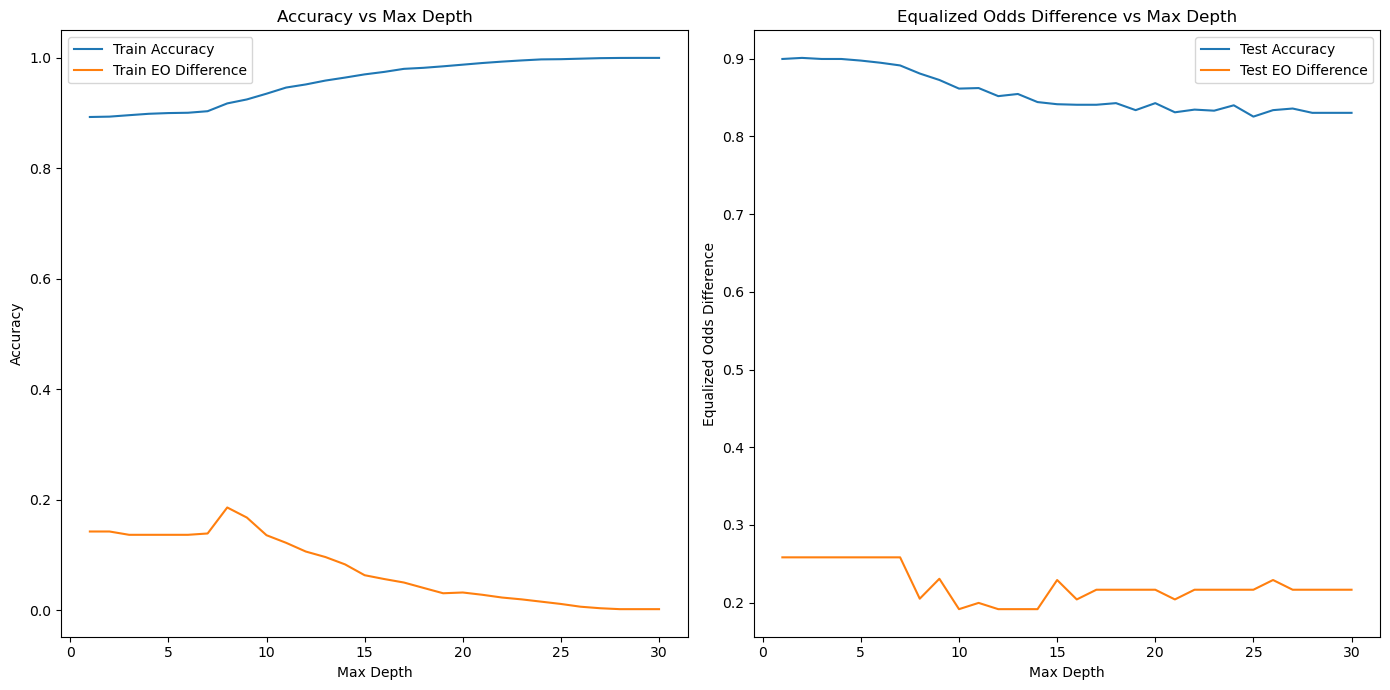

In [48]:

def compute_eod_and_accuracy(clf, X, y, sensitive_attr):
    predictions = clf.predict(X)
    accuracy = accuracy_score(y, predictions)

    # Calculate Equalized Odds Difference using Fairlearn's MetricFrame
    mf = MetricFrame(metrics={
                        'tpr': true_positive_rate, 
                        'fpr': false_positive_rate
                     },
                     y_true=y, 
                     y_pred=predictions, 
                     sensitive_features=sensitive_attr.idxmax(axis=1))
    
    eo_diff = max(mf.difference(method='between_groups')['tpr'], 
                  mf.difference(method='between_groups')['fpr'])
    
    return accuracy, eo_diff

max_depths = range(1, 31)
train_accuracies = []
test_accuracies = []
train_eods = []
test_eods = []

# Ensure sensitive_attr is correctly formatted before looping
sensitive_attr_train = X_train[['combined_category_Adult_Other_Female', 'combined_category_Adult_White_Female', 'combined_category_Young_Other_Female',
                             'combined_category_Young_White_Female', 'combined_category_Adult_Other_Male', 'combined_category_Adult_White_Male', 
                             'combined_category_Young_Other_Male', 'combined_category_Young_White_Male']]

sensitive_attr_test = X_test[['combined_category_Adult_Other_Female', 'combined_category_Adult_White_Female', 'combined_category_Young_Other_Female',
                             'combined_category_Young_White_Female', 'combined_category_Adult_Other_Male', 'combined_category_Adult_White_Male', 
                             'combined_category_Young_Other_Male', 'combined_category_Young_White_Male']]


for depth in max_depths:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    clf.fit(X_train, y_train)

    # Compute metrics for training data
    train_accuracy, train_eod = compute_eod_and_accuracy(clf, X_train, y_train, sensitive_attr_train)
    train_accuracies.append(train_accuracy)
    train_eods.append(train_eod)

    # Compute metrics for testing data
    test_accuracy, test_eod = compute_eod_and_accuracy(clf, X_test, y_test, sensitive_attr_test)
    test_accuracies.append(test_accuracy)
    test_eods.append(test_eod)

    
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.plot(max_depths, train_accuracies, label='Train Accuracy')
plt.plot(max_depths, train_eods, label='Train EO Difference')
plt.title('Accuracy vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(max_depths, test_accuracies, label='Test Accuracy')
plt.plot(max_depths, test_eods, label='Test EO Difference')
plt.title('Equalized Odds Difference vs Max Depth')
plt.xlabel('Max Depth')
plt.ylabel('Equalized Odds Difference')
plt.legend()

plt.tight_layout()
plt.show()



0.8995148995148995


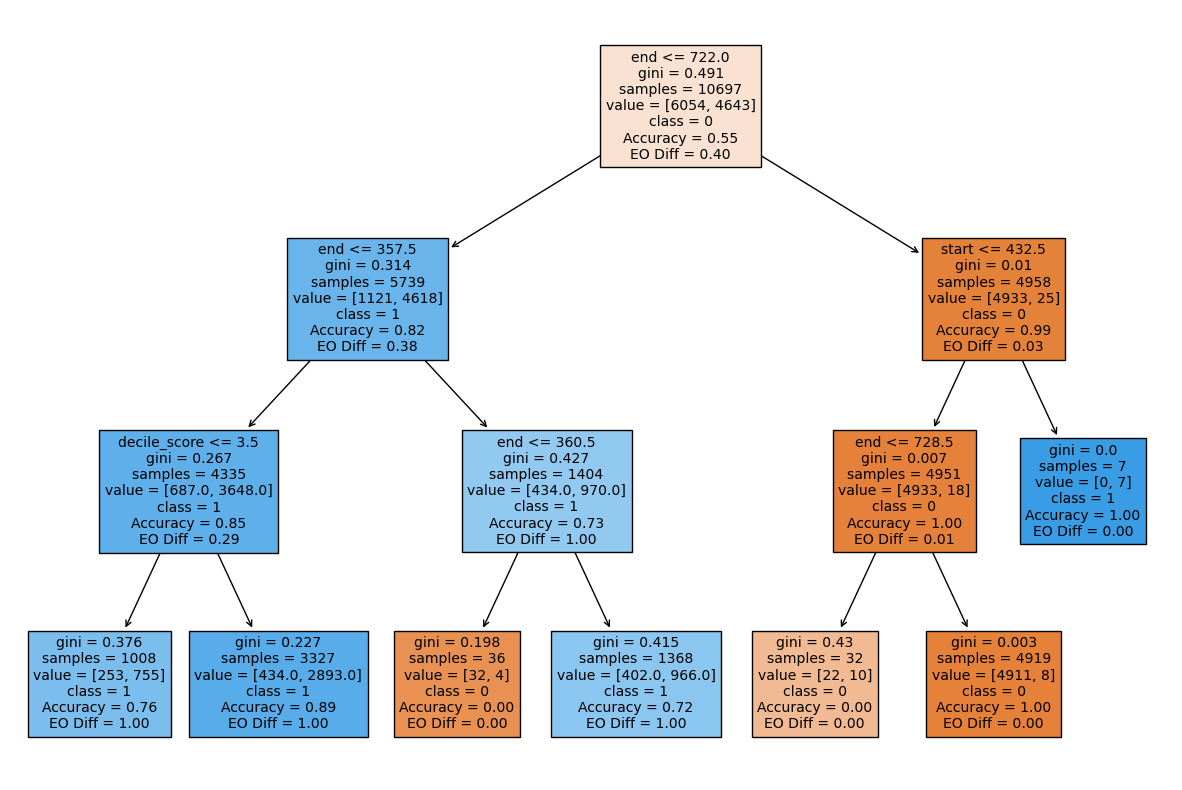

0.8961391044218006
              precision    recall  f1-score   support

           0       0.99      0.82      0.90       793
           1       0.82      0.99      0.90       650

    accuracy                           0.90      1443
   macro avg       0.91      0.91      0.90      1443
weighted avg       0.92      0.90      0.90      1443



In [49]:
import warnings


clf = DecisionTreeClassifier(criterion='gini',max_depth=3,random_state=42)
clf.fit(X_train, y_train)
y_predic = clf.predict(X_test)
print(accuracy_score(y_test, y_predic))

def compute_node_eod(tree, X, y, sensitive_attr):
    accuracies = np.zeros(tree.tree_.node_count)
    eo_diff = np.zeros(tree.tree_.node_count) 
    
    node_indicator = tree.decision_path(X)
    
    for node_id in range(tree.tree_.node_count):
        node_samples = node_indicator[:, node_id].toarray().ravel().astype(bool)
        if not any(node_samples):
            continue  

        node_labels = y[node_samples]
        node_sensitive = sensitive_attr[node_samples]
        
        # Most common label predicted at this node
        most_common = np.argmax(tree.tree_.value[node_id])
        predictions = np.full(len(node_labels), most_common)
        
        accuracies[node_id] = np.mean(predictions == node_labels)
        
        mf = MetricFrame(
            metrics={
                'tpr': true_positive_rate,
                'fpr': false_positive_rate,
                'accuracy_score': accuracy_score
            },
            y_true=node_labels,
            y_pred=predictions,
            sensitive_features=node_sensitive
        )
        
        tpr_diff = mf.difference(method='between_groups')
        fpr_diff = mf.difference(method='between_groups')
        eo_diff[node_id] = max(tpr_diff.max(), fpr_diff.max())  # Maximum difference for EO
        
        #eo_diff[node_id] =  equalized_odds_difference(y_true=y_test, y_pred=y_predic,
                                                      #sensitive_features=sensitive_attr)
    return accuracies, eo_diff



sensitive_attr = X_test[['combined_category_Adult_Other_Female', 'combined_category_Adult_White_Female', 'combined_category_Young_Other_Female',
                             'combined_category_Young_White_Female', 'combined_category_Adult_Other_Male', 'combined_category_Adult_White_Male', 
                             'combined_category_Young_Other_Male', 'combined_category_Young_White_Male']]

node_accuracies, node_eod = compute_node_eod(clf, X_test, y_test, sensitive_attr)

fig, ax = plt.subplots(figsize=(15, 10))
tree_plot = plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=["0", "1"], ax=ax)

# Annotating with accuracies and EO difference
for i, text in enumerate(tree_plot):
    if i < len(node_accuracies):  
        metrics_text = f'\nAccuracy = {node_accuracies[i]:.2f}'
        metrics_text += f'\nEO Diff = {node_eod[i]:.2f}'
        text.set_text(text.get_text() + metrics_text)

plt.show()

y_new = clf.predict(X_train)
print(accuracy_score(y_new, y_train))
print(classification_report(y_test, y_predic))

In [51]:

sensitive_features = X_test[['combined_category_Adult_Other_Female', 'combined_category_Adult_White_Female', 'combined_category_Young_Other_Female',
                             'combined_category_Young_White_Female', 'combined_category_Adult_Other_Male', 'combined_category_Adult_White_Male', 
                             'combined_category_Young_Other_Male', 'combined_category_Young_White_Male']]
sensitive_feature_single = sensitive_features.idxmax(axis=1)

def true_positive_rate(y_true, y_pred):
    return recall_score(y_true, y_pred)


mf_dt = MetricFrame(metrics=true_positive_rate,
                    y_true=y_test,
                    y_pred=y_predic,
                    sensitive_features=sensitive_feature_single)  

# Calculate Equalized Odds Difference using the corrected sensitive_features reference
#eod_lr = equalized_odds_difference(y_true=y_test, y_pred=lr_preds, sensitive_features=sensitive_feature_single)
eod_dt = equalized_odds_difference(y_true=y_test, y_pred=y_predic, sensitive_features=sensitive_feature_single)

#print(f"Equalized Odds Difference for Logistic Regression: {eod_lr}")
print(f"Equalized Odds Difference for Decision Tree: {eod_dt}")

print("\nMetric Frame for Decision Tree:")
print(mf_dt.by_group)

Equalized Odds Difference for Decision Tree: 0.2583333333333333

Metric Frame for Decision Tree:
sensitive_feature_0
combined_category_Adult_Other_Female    1.000000
combined_category_Adult_Other_Male      0.996139
combined_category_Adult_White_Female    1.000000
combined_category_Adult_White_Male      0.973913
combined_category_Young_Other_Female    1.000000
combined_category_Young_Other_Male      1.000000
combined_category_Young_White_Female    1.000000
combined_category_Young_White_Male      1.000000
Name: true_positive_rate, dtype: float64


In [53]:

sensitive_features = X_test[['combined_category_Adult_Other_Female', 'combined_category_Adult_White_Female', 'combined_category_Young_Other_Female',
                             'combined_category_Young_White_Female', 'combined_category_Adult_Other_Male', 'combined_category_Adult_White_Male', 
                             'combined_category_Young_Other_Male', 'combined_category_Young_White_Male']]
sensitive_feature_single = sensitive_features.idxmax(axis=1)

# Define a metric to evaluate the positive prediction rate
def positive_prediction_rate(y_true, y_pred):
    # Here, we ignore y_true because we're interested in the rate of positive predictions, not their correctness
    return np.mean(y_pred)


mf_dt_stat_parity = MetricFrame(metrics=positive_prediction_rate,
                                y_true=y_test,  # This is also necessary but not used
                                y_pred=y_predic,
                                sensitive_features=sensitive_feature_single)

# The difference in positive prediction rates between the most and least favored groups can serve as a measure of statistical parity
#diff_lr_stat_parity = mf_lr_stat_parity.difference(method='between_groups')
diff_dt_stat_parity = mf_dt_stat_parity.difference(method='between_groups')

#print(f"Difference in Positive Prediction Rates for Logistic Regression (Statistical Parity): {diff_lr_stat_parity}")
print(f"Difference in Positive Prediction Rates for Decision Tree (Statistical Parity): {diff_dt_stat_parity}")


print("\nPositive Prediction Rate by Group for Decision Tree:")
print(mf_dt_stat_parity.by_group)

Difference in Positive Prediction Rates for Decision Tree (Statistical Parity): 0.3596265172735761

Positive Prediction Rate by Group for Decision Tree:
sensitive_feature_0
combined_category_Adult_Other_Female    0.378151
combined_category_Adult_Other_Male      0.555357
combined_category_Adult_White_Female    0.444444
combined_category_Adult_White_Male      0.483221
combined_category_Young_Other_Female    0.603774
combined_category_Young_Other_Male      0.737778
combined_category_Young_White_Female    0.500000
combined_category_Young_White_Male      0.507246
Name: positive_prediction_rate, dtype: float64


In [57]:
from sklearn.neighbors import NearestNeighbors
def custom_smote(data, n_samples):
    """
    Custom SMOTE-like function to generate synthetic samples within a single category.
    
    :param data: Data subset belonging to a specific category (numpy array).
    :param n_samples: Number of synthetic samples to generate.
    :return: Synthetic samples generated within the given category.
    """
    # Initialize the synthetic samples array
    synthetic_samples = np.zeros((n_samples, data.shape[1]))
    
    # Fit the NearestNeighbors model to the data
    nn = NearestNeighbors(n_neighbors=7).fit(data)
    neighbors = nn.kneighbors(data, return_distance=False)
    
    # Generate synthetic samples
    for i in range(n_samples):
        # Randomly choose a sample to serve as the base for the synthetic sample
        sample_idx = np.random.randint(data.shape[0])
        # Use one of its nearest neighbors
        nn_idx = np.random.choice(neighbors[sample_idx, 1:])
        
        # Calculate the difference between the sample and its neighbor
        diff = data[nn_idx] - data[sample_idx]
        # Generate a random weight to interpolate between the sample and its neighbor
        weight = np.random.rand(1)
        
        # Create the synthetic sample
        synthetic_samples[i] = data[sample_idx] + weight * diff
    
    return synthetic_samples


def generate_balanced_synthetic_labels(n_samples_needed, balance_ratio):
    """
    Generates a balanced list of class labels for synthetic samples.
    
    :param n_samples_needed: Total number of synthetic samples needed.
    :param balance_ratio: Target ratio of class 1 labels to total labels. 
                          Default is 0.5 for equal balance.
    :return: A list of synthetic labels with the specified balance.
    """
    n_class_1 = int(n_samples_needed * balance_ratio)
    n_class_0 = n_samples_needed - n_class_1  # Adjust to ensure total matches n_samples_needed
    
    synthetic_labels = [0] * n_class_0 + [1] * n_class_1
    np.random.shuffle(synthetic_labels)  # Shuffle to mix class labels
    
    return synthetic_labels


In [58]:
# Load the data
file_path = r"C:\Users\olasu\Downloads\compas_data.csv"
df = pd.read_csv(file_path)


# Combine categories and create a new column for them
df['combined_category'] = df['sex'] + "_" + df['Age_class'] + "_" + df['race_class']
df['Reoffending_Likelihood'] = df['Reoffending_Likelihood'].replace({1: 0, 2: 1}) 


combined_one_hot_encoded = pd.get_dummies(df['combined_category'])
combined_one_hot_encoded.columns = combined_one_hot_encoded.columns.str.lower()

# Join the one-hot encoded data back to the original DataFrame and drop unnecessary columns
new_data = df.join(combined_one_hot_encoded)
new_data.drop(["race_class", "Age_class", "sex", "age"], axis=1, inplace=True)

# Encoding other categorical features
categorical_features = new_data.select_dtypes(include=['object', 'bool'])
for col in categorical_features:
    le = LabelEncoder()
    new_data[col] = new_data[col].fillna('missing')
    new_data[col] = le.fit_transform(new_data[col])
X = new_data.drop(['Reoffending_Likelihood'], axis=1)
y = new_data['Reoffending_Likelihood']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

new_data3= pd.concat([X_train, y_train], axis=1)
categories = new_data3['combined_category'].unique()
max_size = new_data3['combined_category'].value_counts().max()
balanced_df_list = []


for category in categories:
    category_subset = new_data3[new_data3['combined_category'] == category]
    features = category_subset.drop(['Reoffending_Likelihood', 'combined_category'], axis=1)
    n_samples_needed = max_size - category_subset.shape[0]
    
    if n_samples_needed > 0:
        synthetic_features = custom_smote(features.to_numpy(), n_samples_needed)
        synthetic_features_df = pd.DataFrame(synthetic_features, columns=features.columns)
        
        # Generate a balanced distribution of synthetic labels
        synthetic_labels = generate_balanced_synthetic_labels(n_samples_needed, balance_ratio=0.34)
        
        synthetic_features_df['Reoffending_Likelihood'] = synthetic_labels
        synthetic_features_df['combined_category'] = category
        
        category_subset_balanced = pd.concat([category_subset, synthetic_features_df])
    else:
        category_subset_balanced = category_subset
    
    balanced_df_list.append(category_subset_balanced)

balanced_df1 = pd.concat(balanced_df_list).reset_index(drop=True)


# Prepare features and target variable
X_train = balanced_df1.drop(['Reoffending_Likelihood', 'combined_category'], axis=1)  
y_train =balanced_df1['Reoffending_Likelihood'] 

X_test = X_test.drop(['combined_category'], axis=1)
